<a href="https://colab.research.google.com/github/CardosoJr/bootcamp/blob/main/Labs/Lab_15_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Séries Temporais

Vamos entender os principais conceitos envolvendo pré-processamento, análise e modelagem de séries temporais.


In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 500)
import warnings
warnings.simplefilter(action='ignore', category=Warning)
warnings.filterwarnings('ignore')
import math

# Importando libs de plots
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
# sns.set_context('talk')
sns.set_palette('rainbow')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [2]:
#statistics libraries
import statsmodels.api as sm
import scipy
from scipy.stats import anderson
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import month_plot, seasonal_plot, plot_acf, plot_pacf, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox as ljung
#from nimbusml.timeseries import SsaForecaster
from statsmodels.tsa.statespace.tools import diff as diff
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy import signal
from scipy.stats import shapiro
from scipy.stats import boxcox
import scipy.stats as stats
from scipy.stats import jarque_bera as jb
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

In [ ]:
# !pip install -q darts

     |████████████████████████████████| 451 kB 8.0 MB/s 
     |████████████████████████████████| 708 kB 47.0 MB/s 
     |████████████████████████████████| 569 kB 55.8 MB/s 
     |████████████████████████████████| 76 kB 5.2 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 76.8 MB 1.4 MB/s 
     |████████████████████████████████| 11.2 MB 52.6 MB/s 
     |████████████████████████████████| 1.6 MB 43.7 MB/s 
     |████████████████████████████████| 965 kB 43.9 MB/s 
     |████████████████████████████████| 529 kB 48.9 MB/s 


In [3]:
!pip install -q pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.2 MB/s eta 0:00:00


In [4]:
import pmdarima as pm
from pmdarima import ARIMA, auto_arima

## O que são séries temporais?

Séries temporais são observações medidas em intervalos de tempo que podem ser regulares ou não.
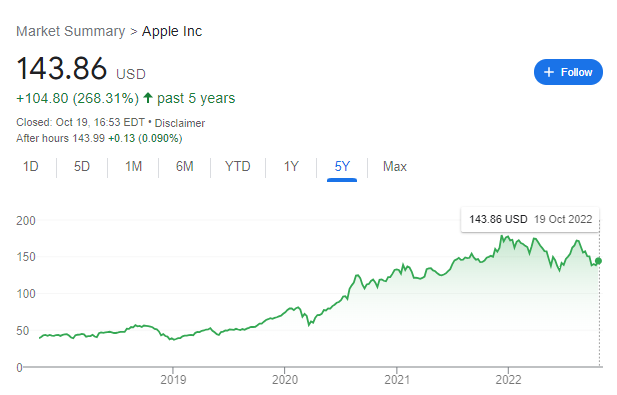

Alguns tipos de dados:
* **Série temporal**: uma variável medida no tempo
* **Cross-sectional**: Mais de uma variável medidas em um único intervalo de tempo
* **Panel data**: Mais de uma variável medidas ao longo do tempo

Tipos de problemas:
- **Univariado**: Temos só uma variável ao longo do tempo. Por exemplo, preços da ação da Apple
- **Multivariado**: Temos mais de uma variável ao longo do tempo. Idealmente, essas variáveis tem algum tipo de correlação com a variável target. Nem todo método de forecasting, suporta o setup multivariado.
  - Variáveis endógenas: possuem correlação com outras variáveis do input
  - Variáveis exógenas: não possuem correlação com outras variáveis do input


## Análises

In [5]:
data = pd.read_csv('https://raw.githubusercontent.com/CardosoJr/bootcamp/main/Datasets/AirPassengers.csv')

In [ ]:
data['Month'] = pd.to_datetime(data['Month'], infer_datetime_format=True)
data.set_index('Month', inplace = True)

In [ ]:
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


### Pré-processamento

* **Missing**: forward-fill ou backward-fill podem ser opções. No caso tradicional de séries temporais, forward-fill é o mais apropriado.
* Avaliar datas **duplicadas**
* As datas são contínuas? Caso não, pode ser necessário tratá-las
* **Outliers**? Existem picos nos dados ou observações muito diferentes? Pode ser necessário tratar. Alguns filtros como médias móveis podem ser úteis. Muitos modelos clássicos não lidam bem com outliers (como ETS e ARIMA). E algumas métricas são muito influencidas por outliers como o RMSE. Outros métodos para tratar outliers:
  * Winsorization: clip valores com excedem os percentis 1% e 99% dentro de uma janela
  * Analisar o desvio padrão residual com os dados observados
* Analisar visualmente tendências, sazonalidade e comportamento cíclico
  * Sazonalidade pode ser descrito como cíclos rápidos (diário, mensal, trimestral)
  * Ciclos podem ser vistos em períodos longos (10 anos e etc) como recessões. Se temos ciclos, podemos escolher uma decomposição do tipo X11 ou STL.
  * Se múltiplas sazonalidades estão presentes, então ETS e ARIMA podem ser prejudicados. Seria melhor por exemplo SSA, TBATS ou harmonic regression. Frequência da sazonalidade é importante.
  * ajuda a escolher o tipo de modelagem (ARIMA x SARIMA ou single, double ou triple exponential smoothing)




In [ ]:
#Any missing data?
print("missing_data:", data.isna().sum().values)
print("unique dates:", data.index.nunique())

missing_data: [0]
unique dates: 144


In [ ]:
pd.crosstab(index=data.index.year, columns=data.index.quarter)

col_0,1,2,3,4
row_0,,,,
1949,3,3,3,3
1950,3,3,3,3
1951,3,3,3,3
1952,3,3,3,3
1953,3,3,3,3
1954,3,3,3,3
1955,3,3,3,3
1956,3,3,3,3
1957,3,3,3,3


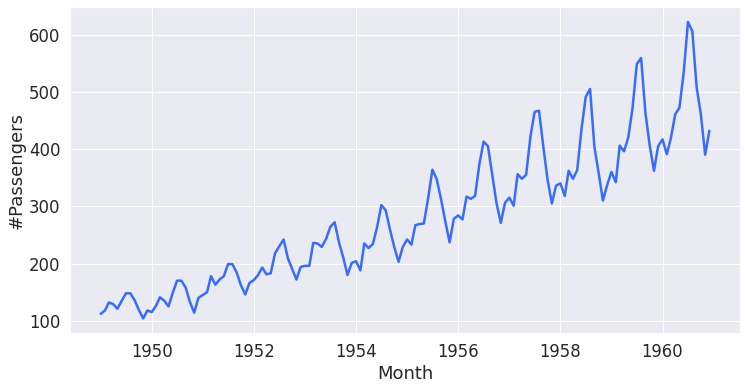

In [ ]:
fig, ax = plt.subplots(figsize = (12, 6))
sns.lineplot(x = data.index, y = data['#Passengers']);

#### Um jeito bem ingênuo de se prever séries temporais:

Vamos apenas considerar que o valor a ser previsto é apenas uma média dos valores anteriores

$\hat{y}_{t} = \frac{1}{k} \displaystyle\sum^{k}_{n=1} y_{t-n}$

In [ ]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")

        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)

    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

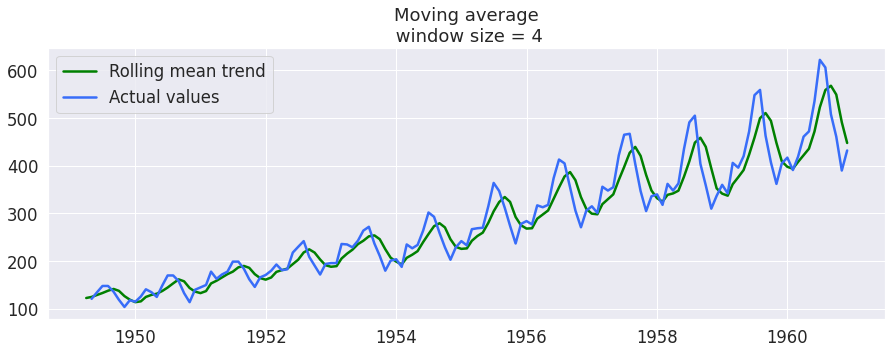

In [ ]:
plotMovingAverage(data['#Passengers'], 4)

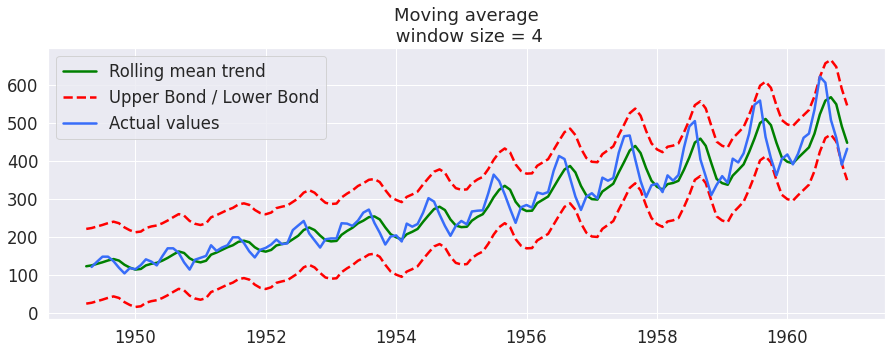

In [ ]:
plotMovingAverage(data['#Passengers'], 4, plot_intervals = True)

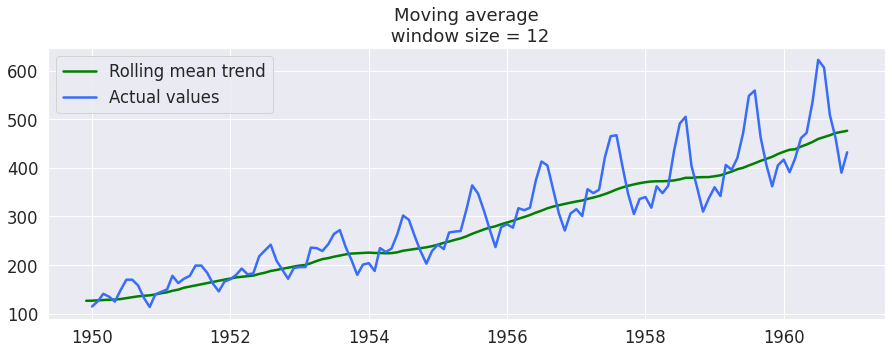

In [ ]:
plotMovingAverage(data['#Passengers'], 12)

### Algumas análises comuns em EDA

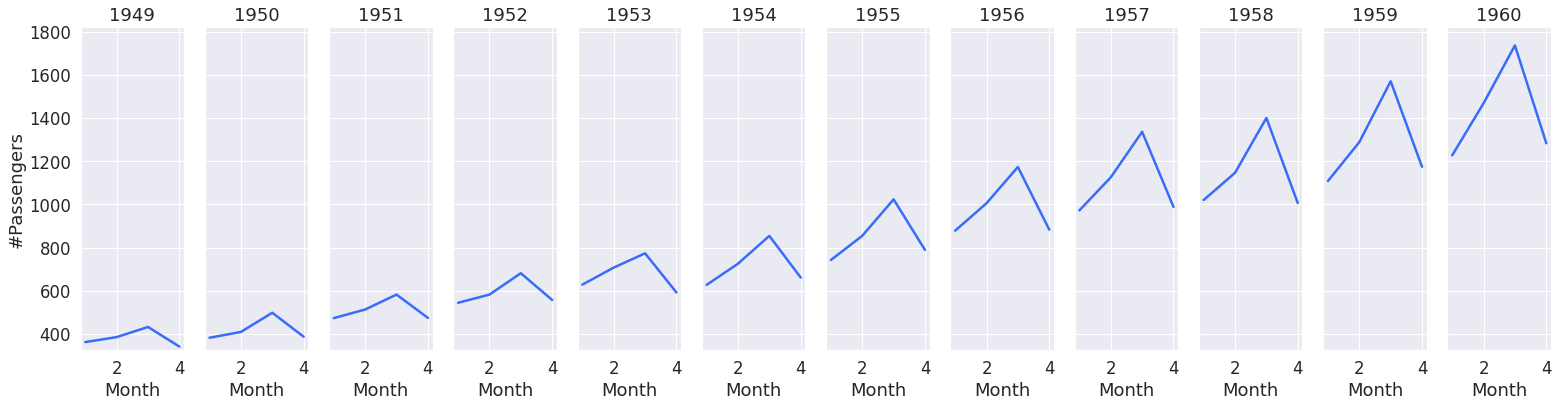

In [ ]:
fig, ax = plt.subplots(1,12, figsize = (22,6), sharey = True)
ax = ax.flatten()

limits = [data.resample('Q').sum()['#Passengers'].min() * 0.95, data.resample('Q').sum()['#Passengers'].max() * 1.05 ]
i = 0
for year, dfg in data.groupby(data.index.year):
  dfg = dfg.resample('Q').sum()
  sns.lineplot(x = dfg.index.quarter, y = dfg['#Passengers'], ax = ax[i]);
  ax[i].set_title(year)
  ax[i].set_ylim(limits)
  i = i + 1

plt.tight_layout()



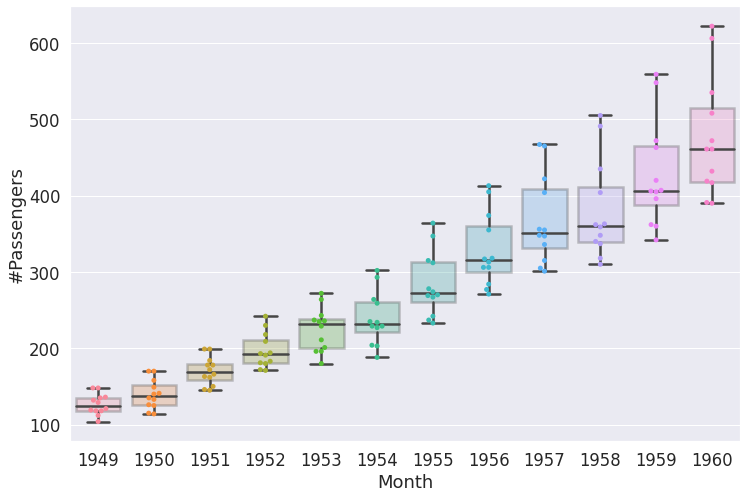

In [ ]:
fig, ax = plt.subplots(figsize = (12,8))
sns.boxplot(data=data, x=data.index.year, y = '#Passengers',  ax = ax, boxprops=dict(alpha=.3));
sns.swarmplot(data=data, x=data.index.year, y = '#Passengers');

In [ ]:
growth = data.groupby(data.index.year)["#Passengers"].sum().pct_change().apply(lambda x: x * 100)
growth

Month
1949          NaN
1950    10.263158
1951    21.837709
1952    15.768854
1953    14.213198
1954     6.185185
1955    18.869899
1956    15.580986
1957    12.236608
1958     3.415517
1959    12.423447
1960    11.167315
Name: #Passengers, dtype: float64

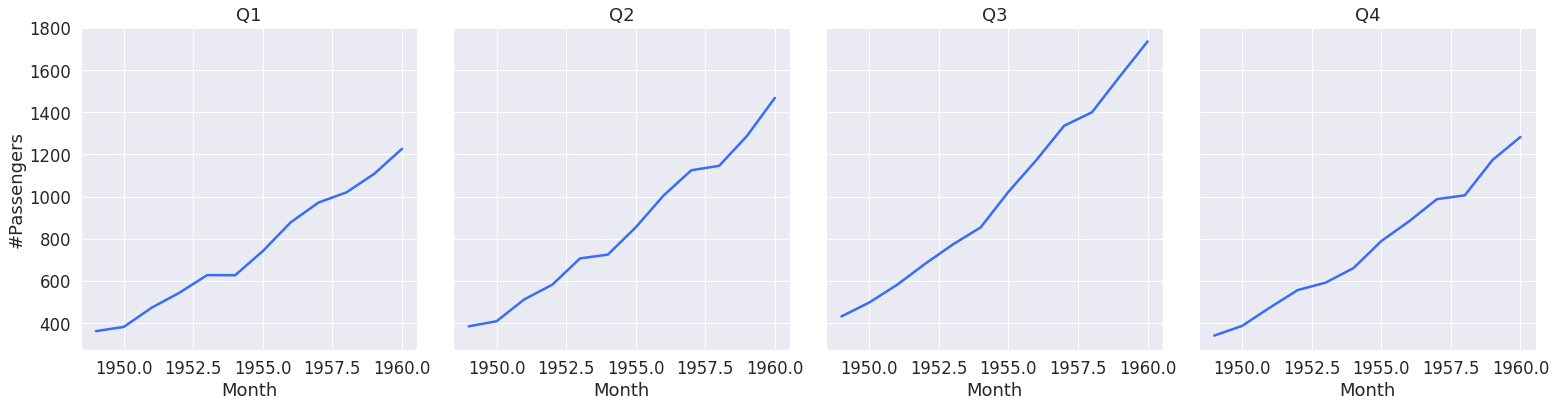

In [ ]:
fig, ax = plt.subplots(1,4, figsize = (22,6), sharey = True)
ax = ax.flatten()

# limits = [data.resample('Q').sum()['#Passengers'].min() * 0.95, data.resample('Q').sum()['#Passengers'].max() * 1.05 ]
i = 0
data_quarter = data.resample('Q').sum()

for quarter, dfg in data_quarter.groupby(data_quarter.index.quarter):
  sns.lineplot(x = dfg.index.year, y = dfg['#Passengers'], ax = ax[i]);
  ax[i].set_title("Q" + str(quarter))
  # ax[i].set_ylim(limits)
  i = i + 1

plt.tight_layout()



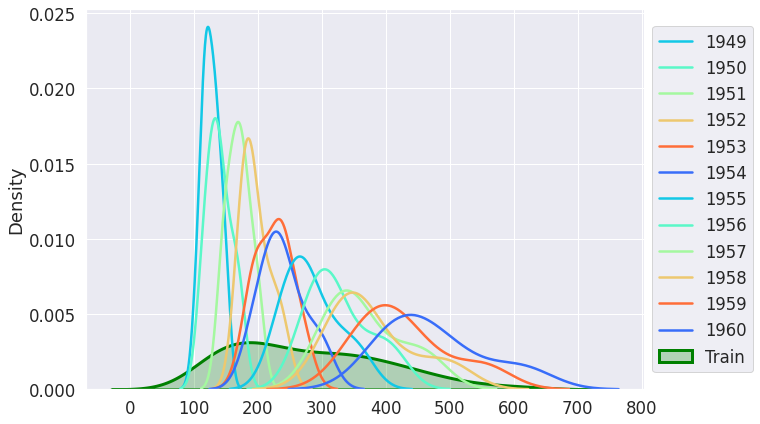

In [ ]:
fig,ax = plt.subplots(figsize = (10, 7))
sns.distplot(data,         label='Train', hist=False, kde_kws={"color": "g", "lw": 3, "label": "Train","shade":True}, ax = ax)

for year in data.index.year.unique():
  sns.distplot(data[data.index.year == year], label=year, hist=False, ax = ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


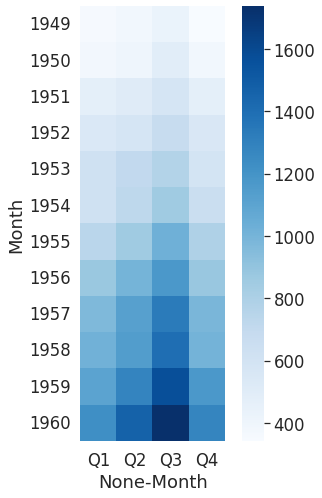

In [ ]:
fig,ax = plt.subplots(figsize = (6, 8))

sns.heatmap(pd.pivot_table(data=data, index=data.index.year, columns=data.index.quarter, aggfunc = 'sum'),
           square=True,
           cmap='Blues',
           xticklabels=["Q1", "Q2", "Q3", "Q4"]);

#### Sazonalidade

In [ ]:
data_diff = data.resample('Q').sum().diff().dropna()

qrt_avg=data_diff.groupby(data_diff.index.quarter)["#Passengers"].mean()

qrt_table = pd.pivot_table(data_diff, index=data_diff.index.quarter, columns=data_diff.index.year)

qrt_table["avg"] = qrt_avg

qrt_table["additive"] = qrt_table["avg"]-data_diff.mean().values

qrt_table["multiplicative"] = (qrt_table["avg"]/data_diff.mean().values).round(2)

qrt_table.index.name="Quarters"

qrt_table

#Passengers                                                          \
Month           1949   1950   1951   1952   1953   1954   1955   1956   1957   
Quarters                                                                       
1                NaN   41.0   86.0   70.0   71.0   35.0   81.0   89.0   89.0   
2               23.0   27.0   40.0   38.0   79.0   98.0  112.0  127.0  153.0   
3               47.0   89.0   69.0   99.0   66.0  129.0  169.0  168.0  211.0   
4              -91.0 -111.0 -108.0 -124.0 -181.0 -193.0 -234.0 -290.0 -348.0   

                                      avg    additive multiplicative  
Month      1958   1959   1960                                         
Quarters                                                              
1          32.0  102.0   53.0   68.090909   48.495164           3.47  
2         126.0  180.0  241.0  103.666667   84.070922           5.29  
3         254.0  282.0  268.0  154.250000  134.654255           7.87  
4        -394.0 -396.0 -453.0 -243.583333 -263.179078         -12.43

### Decomposição
- vamos decompor a série em componentes de nível, tendência e sazonalidade. Temos também o erro residual
- É importante avaliar:
  - A tendência está constante, crescendo ou decrescendo. Tem comportamento linear, exponencial ou alguma função não-linear?
 - A sazonalidade é um padrão repetitivo?
 - Como a sazonalidade está mudando em relação ao nível. Se for constante, a sazonalidade é aditiva, agora se estiver aumentando, pode ser multiplicativa.

Podemos pensar nas séries como:
* **Additive**: $y(t) = Level + Trend + Seasonality + Noise$
* **Multiplicative**: $y(t) = Level * Trend * Seasonality * Noise$

**Para múltiplas sazonalidades checar [aqui](https://medium.com/analytics-vidhya/multi-seasonal-time-series-analysis-decomposition-and-forecasting-with-python-609409570007) e [aqui](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.MSTL.html)**


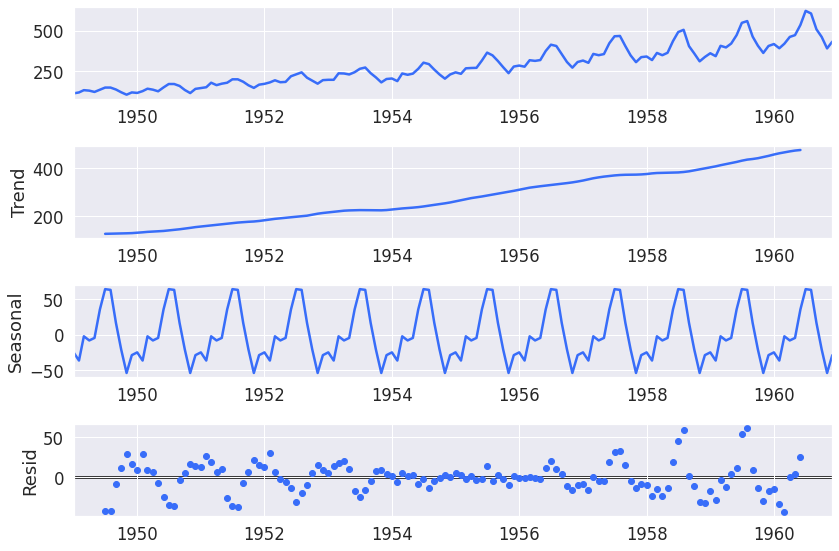

In [ ]:
decompose = seasonal_decompose(data)
decompose.plot();
plt.rcParams['figure.figsize'] = (12, 8);


1. A tendência não é puramente linear.
2. O padrão de sazonalidade é consistente
3. Os resíduos (aquilo que resta ao subtrair a tendência e sazonalidade). É a componente que não conseguimos explicar. Queremos que os resíduos sejam não-correlacionados. Se houver algum padrão nos resíduos, então pode ser que não conseguimos mapear alguma informação em nossa decomposição.
  - Os resíduos estão mostrando um padrão oscilatório, o que não é um bom indicativo. Vamos aplicar o teste estatístico de Ljung Box para confirmar se são *i.i.d.* (ou não correlacionados).
4. Não queremos ver nenhum padrão reconhecível nos resíduos, e.g. oscilações, tendências crescentes ou decrescentes, padrões de funil e etc.


In [ ]:
ljung_p = np.mean(ljung(x=decompose.resid.dropna() - 1)['lb_pvalue']).round(3)
print("Ljung Box, p value:", ljung_p, ", Residuals are uncorrelated" if ljung_p>0.05 else ", Residuals are correlated")

Ljung Box, p value: 0.0 , Residuals are correlated


Os resíduos são correlacionados. Podemos aplicar algumas transformações para verificar se estabilizamos a variância. Pode também ser indicativo que precisamos de alguma variável exógena para explicar completamente o comportamento dessa série.

No caso dessa série em questão, vemos que possui uma sazonalidade multiplicativa. Então, devemos especificar este comportamento na decomposição.

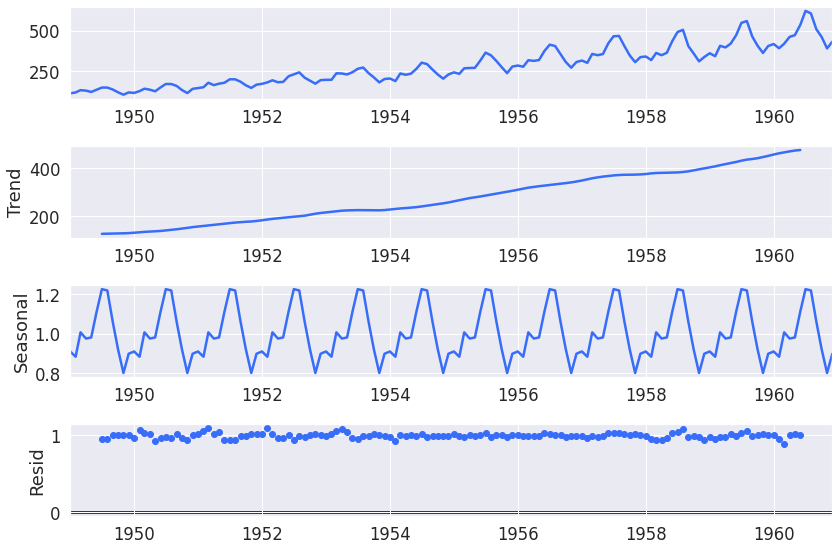

In [ ]:
decompose = seasonal_decompose(data, model = 'multiplicative')
decompose.plot();
plt.rcParams['figure.figsize'] = (12, 8);

In [ ]:
ljung_p = np.mean(ljung(x=decompose.resid.dropna())['lb_pvalue']).round(3)
print("Ljung Box, p value:", ljung_p, ", Residuals are uncorrelated" if ljung_p>0.05 else ", Residuals are correlated")

Ljung Box, p value: 0.0 , Residuals are correlated


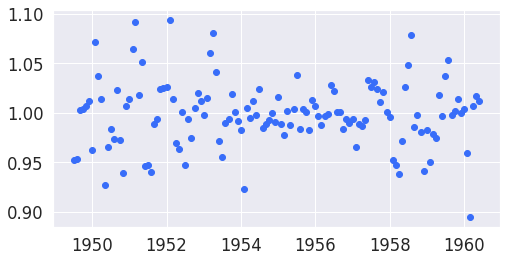

In [ ]:
fig, ax = plt.subplots(figsize = (8,4))
plt.plot(decompose.resid.dropna().index, decompose.resid.dropna().values, 'o');

Apesar de que os resíduos são correlacionados, não vemos um tendência clara. Então, a decomposição multiplicativa seria melhor. No entanto, podemos explorar mais outros tipos de decomposição e transformação para resolver este problema.

### Estacionariedade

- Estacionariedade estatística significa que a série temporal tem média e variância constantes e a autocorrelação possui valores estatisticamente insignificantes em todos os lags. Autocorrelação é uma medida de correlação do valor atual com valores passados (ou lags). Este conceito é fundamental para métodos do tipo ARIMA que só lidam com processos estacionários. Modelos do tipo ETS podem lidar com processos não-estacionários.

- Um dos conceitos mais importantes é que séries temporais são processos estocásticos ou probabilísticos. E os dados que temos mapeados é apenas uma realização desse processo estocástico. Se tivéssemos o contrário, um processo determínistico, os valores futoros poderiam ser aproximados exatamente por alguma função matemática, e.g. $y = sin(2\pi ft)$. Em nosso caso, valores futuros são expressos em termos de distribuições de probabilidade. Quando fazemos estimativas pontuais, as previsões são médias ou medianas dessas distribuições. Porém, é necessário que os usuários de tais modelos estejam cientes das incertezas envolvendo processos de natureza probabilística.
            
Algumas diferenças que precisam estar claras:

- ***White Noise*** (ou ruído branco): Se uma série temporal tem média zero e variância constante, i.e., $N(0,\sigma^2)$, é considerada um ruído branco. As variáveis são independentes e identicamente distribuídas (i.i.d.) e não são correlacionadas. Queremos que o resíduo após o fit de um modelo seja um ruído branco. Esse tipo de dado pode ser identificado utilizando o teste estatístico Augmented Dicky Fuller (ADFuller) e também com plots de autocorrelação (ACF). Em um ACF, a autocorrelação deve ser insignificante em todos os lags (dentro da faixa de 95% CI)
- ***Random Walk***: Random walks são não-estacionários. A média e variância mudam ao longo do tempo. Não podemos fazer forecast de Random walk, pois temos mais unknowns do que dados. Em essência, random walk não possui padrões, um valor futuro é o anterior mais um sinal aleatório. Portanto, se ao tomar a primeira diferenciação dessa série e obter um ruído branco, é um grande indicativo de que a série é um random walk. Geralmente, preços de ações são random walks.
        `Next Data point = Previous Data Point + Random Noise`
        `Random Noise = Next Data Point - Previous Data Point`

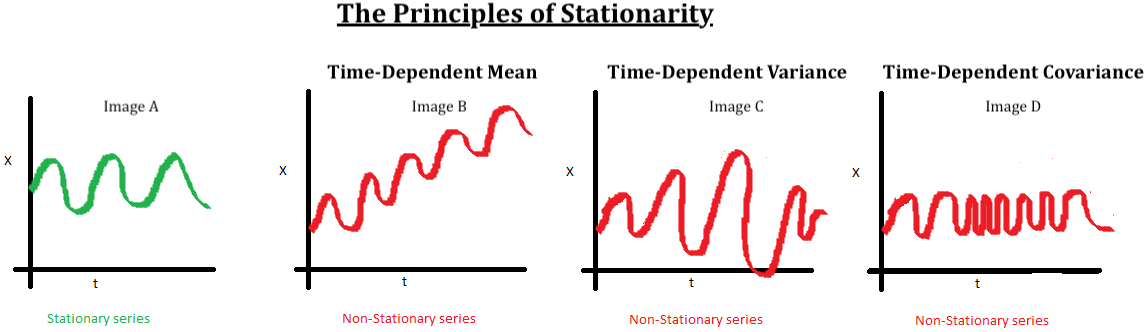

Para que uma série temporal seja estacionária, é necessário:
- média constante
- variância constante
- covariância constante (não-correlacionada)

Alguns testes estatísticos para verificar estacionariedade:
* Augmented Dicky Fuller test (ADFuller)
* Kwiatkowski-Phillips-Schmidt-Schin test (KPSS - stationary trend)
* Phillips Perron test (PP)

Mean is: 280.2986111111111


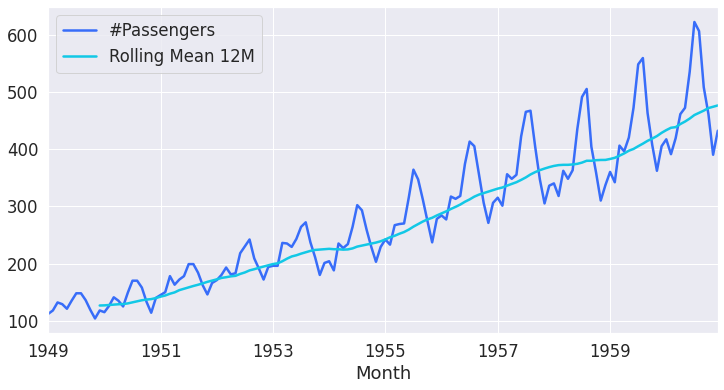

In [ ]:
data.plot(figsize=(12,6), legend=True, label="Train")
data["#Passengers"].rolling(12, center=False).mean().plot(legend=True, label="Rolling Mean 12M");
print("Mean is:", data["#Passengers"].mean())

Vemos que a média se altera para cada ano e as diferenças entre a média e os valores máximos dentro de um ciclo aumentam, indicando uma sazonalidade multiplicativa.

S.D is: 120.0


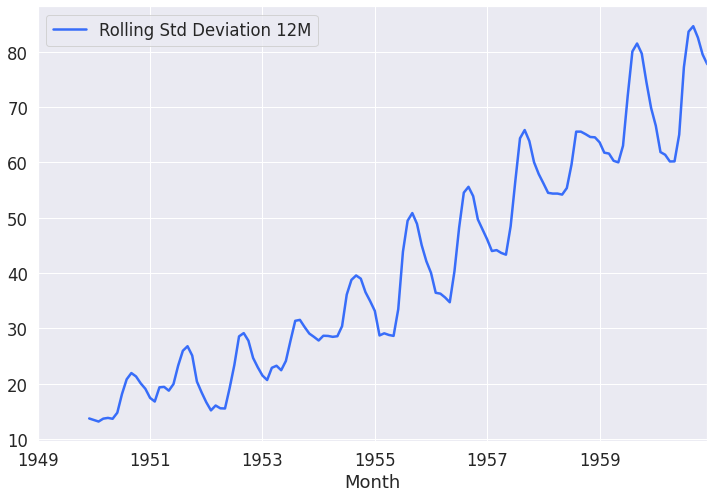

In [ ]:
data["#Passengers"].rolling(12).std().plot(legend=True, label="Rolling Std Deviation 12M");
print("S.D is:", data["#Passengers"].std().round(1))

Tanto a média quanto desvio-padrão estão aumentando, indicando que a série não é estacionária.

#### Augmented Dicky Fuller test

In [ ]:
#Calculate ad fuller statistic
adf = adfuller(data["#Passengers"])[1]
print(f"p value:{adf.round(4)}", ", Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")

p value:0.9919 , Series is Non-Stationary


#### Coefficient of Variation
Coeficiente de variação nos da uma ideia sobre a variabilidade do processo. Este é um indicador empírico e não tem uma definição estatística estrita.

c.v = s.d/mean

If C.V<0.75     => Low Variability

If 0.75<C.V<1.3 => Medium Variability

If C.V>1.3      => High Variability


In [ ]:
cv = data["#Passengers"].std()/data["#Passengers"].mean()
cv.round(2)

0.43

#### Auto-correlação

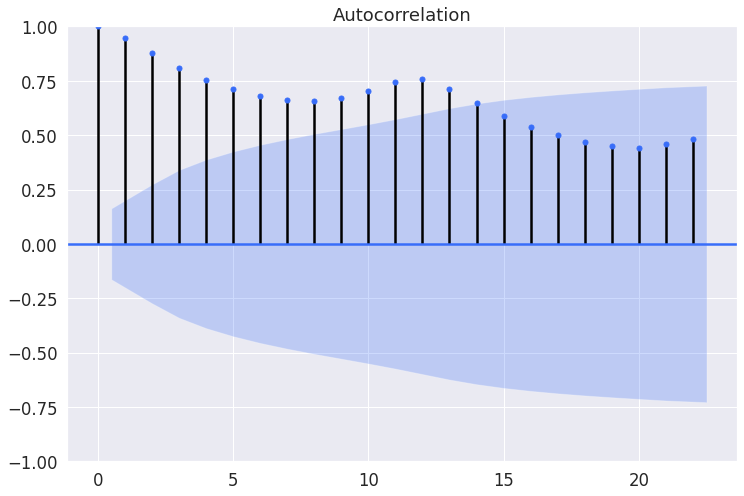

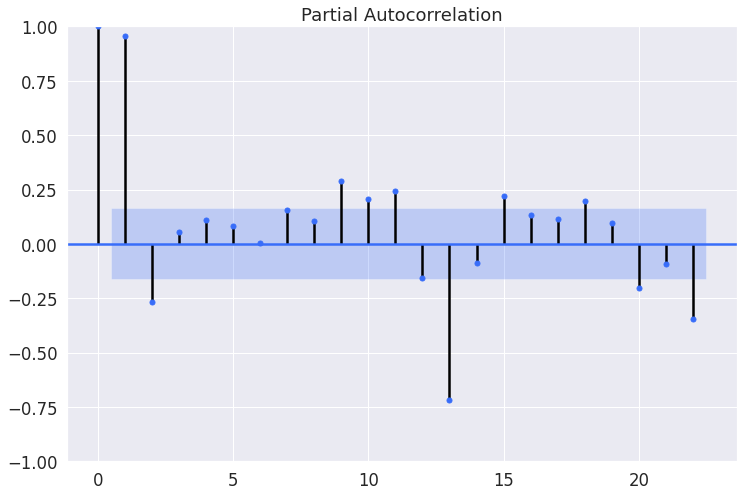

In [ ]:
plot_acf(data);
plot_pacf(data);

#### Observações:
1. ACF: Existem correlações significativas até o lag 14 (valores acima da faixa azul - 95% CI). ACF nos ajuda a determinar a ordem de processos MA. Ao analisar ACF, é importante analisar os seguintes pontos:
    - *Existe algum lag significativo*, Se sim, a série correlacionada consigo mesma nesses lags.
    - *O quão rápido as barras de mudam*: Se as barras caem rápido, pode ser a presença de uma tendência.
    - *Padrões*: Se o ACF mostra um padrão repetitivo de subidas e descidas, podem representar algum tipo de sazonalidade.
    - *Sinal*: Sinais se alternando, pode representar um processo de mean-reversing. Se todas autocorrelações são positivas ou negativas, pode ser um processo com momentum.



2. PACF: Partial autocorrelation, similar ao cálculo de correlação parcial. Remove o efeito de correlações já explicadas por lags anteriores. Se uma série possui um PACF significativo em um lag $k$, então controlando pelos outros lags $< k$, o lag $k$ tem uma correlação significativa. PACF é utilizado para determinar a ordem de processos AR.

2. ADFuller mostrou que a série é não-estacionária. Podemos aplicar algumas transformações para resolver este problema.

p value:0.0005081681904287542 , Series is Stationary


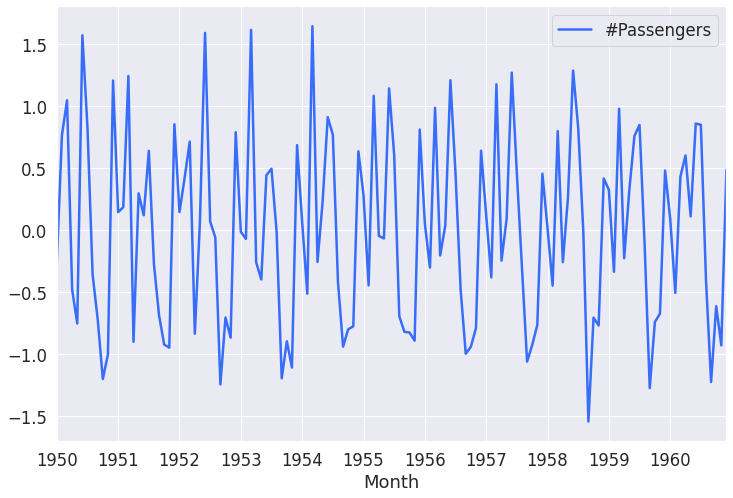

In [ ]:
#De-trending
de_trended = data.apply(lambda x: (x - x.rolling(12).mean()) / x.rolling(12).std()).diff().dropna()
adf2 = adfuller(de_trended)[1]
print(f"p value:{adf2}", ", Series is Stationary" if adf2 <0.05 else ", Series is Non-Stationary")
de_trended.plot();


#### Lag Plots

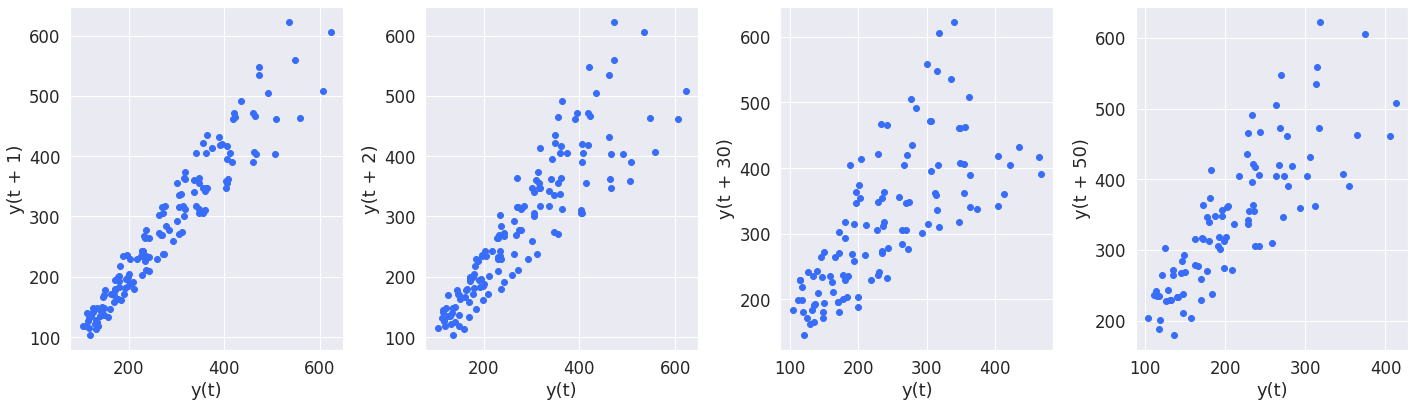

In [ ]:
fig, ax = plt.subplots(1, 4, figsize = (20, 6))
pd.plotting.lag_plot(data["#Passengers"], 1, ax = ax[0]);
pd.plotting.lag_plot(data["#Passengers"], 2, ax = ax[1]);
pd.plotting.lag_plot(data["#Passengers"], 30, ax = ax[2]);
pd.plotting.lag_plot(data["#Passengers"], 50, ax = ax[3]);

plt.tight_layout()

Vemos que essa relação linear forte dos primeiros lags, diminui em lags mais altos

#### Quais frequências são mais dominantes?

*Periodogram*: Analisamos as frequências e suas intensidades. Abaixo, invertemos a frequência para se encontrar o período  `Period,T = 1/frequency`.

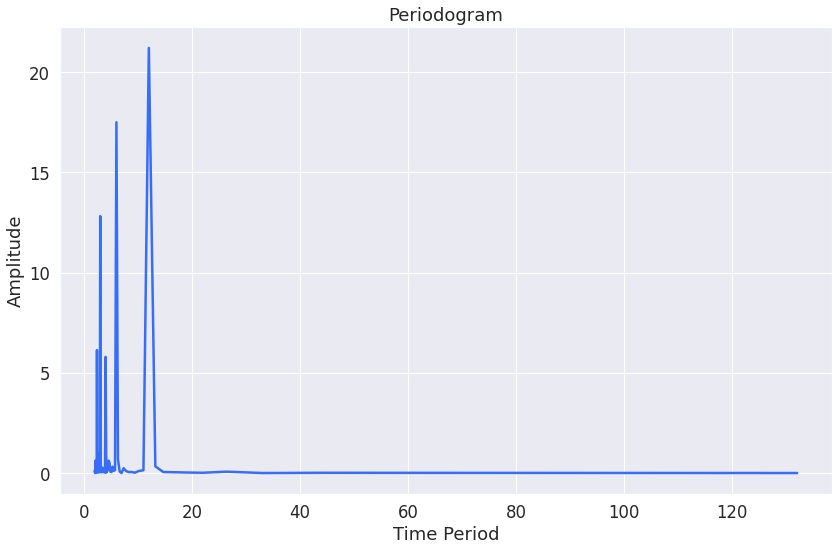

In [ ]:
f, fx = signal.periodogram(de_trended['#Passengers'])
freq = f.reshape(len(f),1) #reshape the array to a column
psd = fx.reshape(len(f),1)
plt.plot(1/freq, psd  )
plt.title("Periodogram")
plt.xlabel("Time Period")
plt.ylabel("Amplitude")
plt.tight_layout()

*Power Spectral Density* (PSD): Um periodograma assume que as frequências  são harmôncias a frequência fundamental do sinal, enquanto o PSD permite as frequências do sinal a variarem de forma contínua. PSD é calculada a partir do ACF. Spectral density é a quantidade de variação por intervalo de frequência. Esse tipo de análise é mais usado com sinais contínuos em plantas industriais. O plot abaixo indica que as frequências mais baixas dominam a série. Os picos em frequências maiores podem indicar comportamento cíclico. Este plot pode ser útil para ajudar a entender os processos MA e AR.

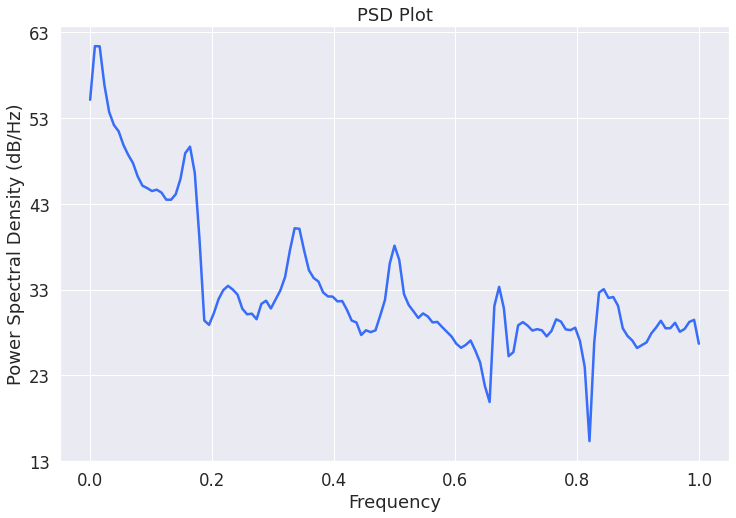

In [ ]:
#Plot PSD
plt.psd(data["#Passengers"], detrend='linear');
plt.title("PSD Plot");

### Transformações

- Enquanto dado distribuído de forma normal não é um requisito para forecasting, pode ajudar a estabilizar a variância da série e reduzir os intervlos de predição.
- Plotar o histograma / KDE para cada período
- Dados distribuídos seguindo uma Normal não são um requesito, porém podem ajudar a estabilizar a variância e reduzir o intervalo de previsão.
- Plot the histogram/KDE para cada período pode ser útil para entender tendências ao longo do tempo.
- Se o data é severemente skewed (possui caudas alongadas), normalizar os dados antes do treinamento deve ser considerado. Cuidado com data leakage para aplicar as transformações nos dados de treino e teste. Estabilizar a variância utilizando transformação de Box Cox, pode ajudar mais que normalizar os dados.
- É necessário analisar e, potencialmente, corrigir outliers antes das transformações.
- Plotar as distribuições também pode ajudar a lidar com problema de concept-drift nos dados. Mais a frente vamos introduzir técnicas de point change estimation.
- Muitas incertezas nos dados de treino, vai resultar em incertezas nos forecasts. Se o dado é muito volátil, ETS e ARIMA podem não ser adequados. Talvez necessário considerar GARCH ou outros métodos.

#### Normalidade

Não é necessário que uma série temporal seja distribuída como uma Distribuição Normal para que seja factivel o forecasting. Porém, distribuições highly skewed pode trazer altas incertezas.

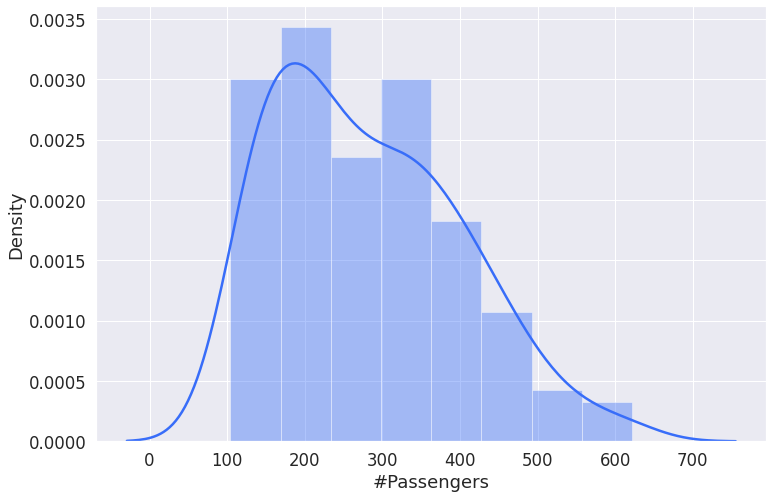

In [ ]:
sns.distplot(data["#Passengers"]);

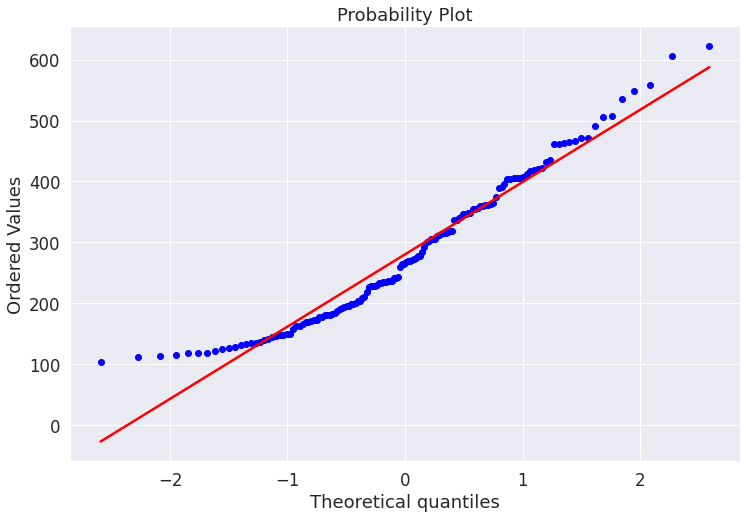

In [ ]:
stats.probplot(data["#Passengers"].values, dist="norm", plot = plt);

In [ ]:
from scipy.stats import jarque_bera as jb
is_norm=jb(data["#Passengers"])[1]
print(f"p value:{is_norm.round(2)}", ", Series is Normal" if is_norm >0.05 else ", Series is Non-Normal")


p value:0.01 , Series is Non-Normal


Como já vimos, diferenciar uma série pode ajudar deixar sua distribuição mais comportada. Outras operações:
* Log
* Box-cox transformation
* Tomar a raiz de grau $n$

## Modelagem

Alguns conceitos:

* **Demanda Intermitente**
     - A série é intermitente quando temos vários zeros ou valores pequenos (em relação aos demais). ETS and ARIMA não são apropriados para esse tipo de dado. Método de Croston é mais utilizado nesses casos.

* **Precisamos de variáveis exógenas?**
  - Pode ser necessário incluir novas variáveis para capturar as tendências de forma mais precisa. Por exemplo, as vendas de um e-commerce podem ser maiores em feriados ou finais de semana. Usar alguma variável com 'dia da semana' ou uma variável dummy de 'feriado' pode ser útil. Modelos ETS não podem usar variáveis exógenas. SARIMAX (X é de variáveis exógenas), deep learning, Gradient Boosting são mais apropriados.
  - Sempre inspecionar os resíduos após treinamento. Se os resíduos são correlacionados (utilizar os plots ACF/PACF e teste de Ljung Box), é uma forte evidência de que os modelos não estão capturando todo comportamentop das séries.

* **Stakeholders preferem forecats para períodos individuais ou algo mais hierárquico?**
  - Pode ser necessário compor as previsões em granularidades maiores, por exemplo, compor as previsões de 12 meses em um ano. De forma ingênua, pode-se somar as previsões dos 12 meses, porém essa seria uma forma incorreta. Séries temporais são processos estocásticos. Seria mais correto simular valores potenciais (segundo intervalo de previsão) e compor o resultado.     

* **Explicabilidade e Interpretabilidade são importantes?**
  - Métodos tradicionais como ETS e ARIMA são fáceis de ser interpretados. Modelos mais complexos como RNNs, Xgboost e outros podem ter maior acurácia, mas são pouco explicáveis. Famoso tradeoff entre acurácia x explicabilidade.

**Passo-a-passo**
   1. EDA
   2. Forecast on test set
   3. Evaluate the forecast
       - Use uma métrica apropriada (%MAPE, RMSE, AIC)
       - Plotar o forecast juntamente os dados de treino e de teste
   4. Check residuals.
       - Plotar resíduos. Plot ACF/PACF e Q/Q plots. Analisar as correlações dos resíduos.
       - Condições 1 e 2 abaixo são essenciais, elas garantem que não existem informação que não foi mapeada pelo modelo. 3 e 4 são desejáveis, pois ajudam a manter variabilidade dos forecasts mais controlada. Os resíduos devem ser:
            1. Não-correlacionados
            2. Média zero
            3. Variância constante
            4. Distribuídos seguindo uma Normal
   5. Selecionar os melhores modelos:
       - Considerar erro dos point forecasts
       - Considerar o intervalo de predição e as incertezas.

### Métricas

- [R squared](http://scikit-learn.org/stable/modules/model_evaluation.html#r2-score-the-coefficient-of-determination): coefficient of determination (pode ser explicado na quantidade de variância explicada pelo modelo), $(-\infty, 1]$

$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$

---
- [Mean Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-error): é uma boa métrica interpretável, pois está na mesma unidade de medida da série temporal, $[0, +\infty)$

$MAE = \frac{\sum\limits_{i=1}^{n} |y_i - \hat{y}_i|}{n}$

---
- [Median Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#median-absolute-error): também é uma métrica interpretável. É mais robusta a outliers, $[0, +\infty)$

$MedAE = median(|y_1 - \hat{y}_1|, ... , |y_n - \hat{y}_n|)$

---
- [Mean Squared Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error): uma das métricas mais comuns, penaliza mais erros maiores, $[0, +\infty)$

$MSE = \frac{1}{n}\sum\limits_{i=1}^{n} (y_i - \hat{y}_i)^2$

---
- [Mean Squared Logarithmic Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-logarithmic-error): praticamente o mesmo do MSE, porém tomamos o log da série temporal. Como resultado, também penalizamos erros pequenos. Esse comportamento é desejado com séries temporais com tendência exponencial, $[0, +\infty)$

$MSLE = \frac{1}{n}\sum\limits_{i=1}^{n} (log(1+y_i) - log(1+\hat{y}_i))^2$

---
- Mean Absolute Percentage Error: é o mesmo que o MAE, porém convertido para porcentagem. É bem conveniente para ser apresentado à pessoas de negócio, $[0, +\infty)$

$MAPE = \frac{100}{n}\sum\limits_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i}$

Como regra geral, se **não** temos outliers, RMSE é uma boa métrica. %MAPE é mais intuitivo, pois é expresso em porcentagem. Não devemos usar %MAPE se a série intermitente para evitar divisões por zero.

In [ ]:
def accuracy(y1,y2):
    accuracy_df=pd.DataFrame()
    rms_error = np.round(rmse(y1, y2),1)
    map_error = np.round(np.mean(np.abs((np.array(y1) - np.array(y2)) / np.array(y1))) * 100,1)
    accuracy_df=accuracy_df.append({"RMSE":rms_error, "%MAPE": map_error}, ignore_index=True)
    return accuracy_df


### Avaliar resíduos

In [ ]:
def residcheck(residuals, lags):
    resid_mean = np.mean(residuals)
    lj_p_val = np.mean(ljung(x=residuals, lags=lags)['lb_pvalue'])
    norm_p_val =  jb(residuals)[1]
    adfuller_p = adfuller(residuals)[1]



    fig = plt.figure(figsize=(10,8))
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2);
    acf_ax = plt.subplot2grid(layout, (1, 0));
    kde_ax = plt.subplot2grid(layout, (1, 1));

    residuals.plot(ax=ts_ax)
    plot_acf(residuals, lags=lags, ax=acf_ax);
    sns.kdeplot(residuals);
    #[ax.set_xlim(1.5) for ax in [acf_ax, kde_ax]]
    sns.despine()
    plt.tight_layout();

    print("** Mean of the residuals: ", np.around(resid_mean,2))

    print("\n** Ljung Box Test, p-value:", np.around(lj_p_val,3), "(>0.05, Uncorrelated)" if (lj_p_val > 0.05) else "(<0.05, Correlated)")

    print("\n** Jarque Bera Normality Test, p_value:", np.around(norm_p_val,3), "(>0.05, Normal)" if (norm_p_val>0.05) else "(<0.05, Not-normal)")

    print("\n** AD Fuller, p_value:", np.around(adfuller_p,3), "(>0.05, Non-stationary)" if (adfuller_p > 0.05) else "(<0.05, Stationary)")

    return ts_ax, acf_ax, kde_ax


### Avaliação de Modelos

Como podemos fazer train-test split de séries temporais?


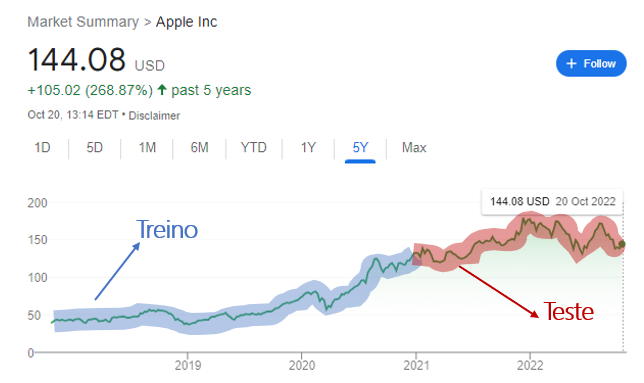

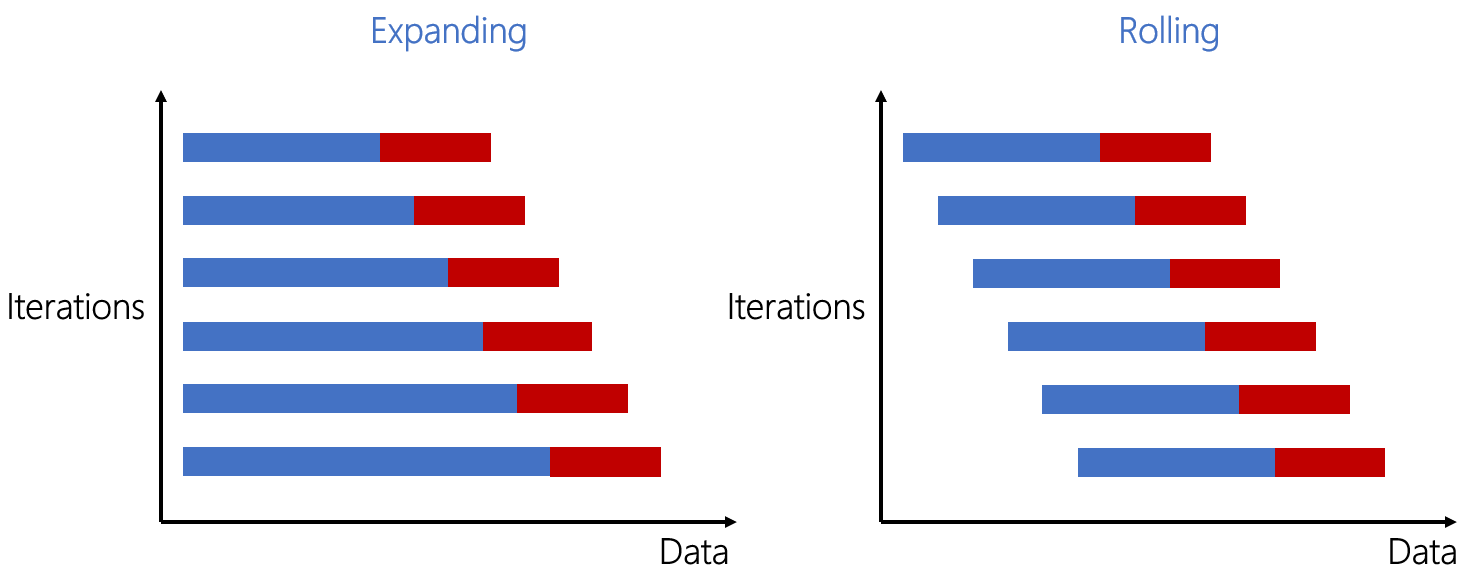

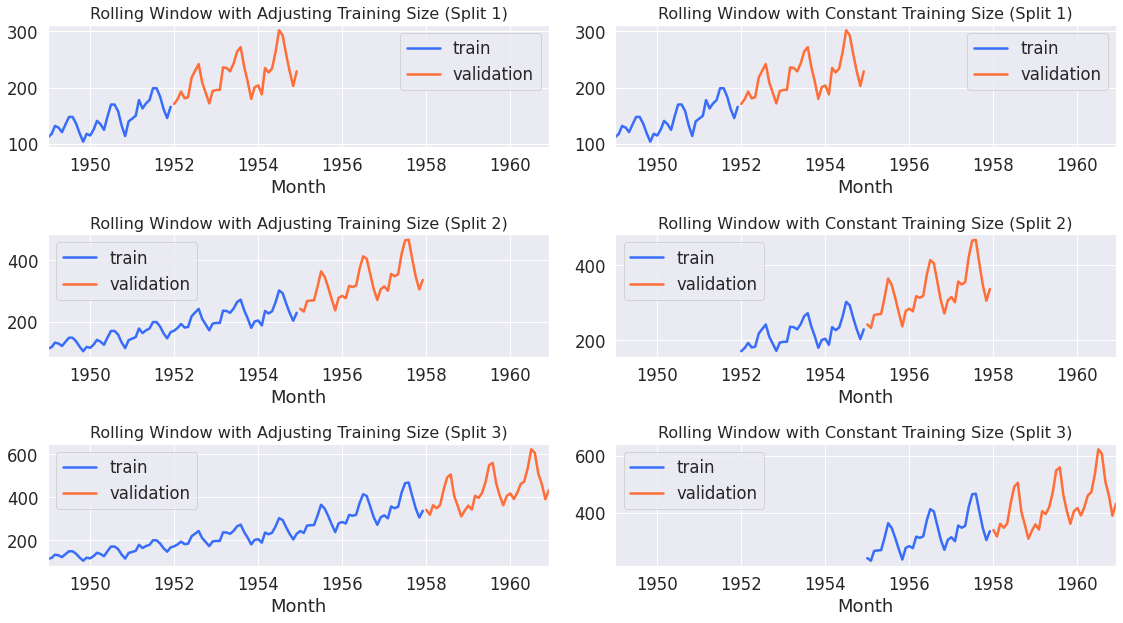

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from datetime import date

N_SPLITS = 3

X = data.index

folds = TimeSeriesSplit(n_splits=N_SPLITS)

f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16, 9))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = data.loc[X_train], data.loc[X_valid]

    sns.lineplot(
        x=X_train,
        y=y_train.values.squeeze(),
        ax=ax[i,0],
        color='#386df9',
        label='train'
    )
    sns.lineplot(
        x=X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))],
        y=y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))].values.squeeze(),
        ax=ax[i,1],
        color='#386df9',
        label='train'
    )

    for j in range(2):
        sns.lineplot(x= X_valid, y= y_valid.values.squeeze(), ax=ax[i, j], color='#ff6d38', label='validation')
    ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)

for i in range(N_SPLITS):
    ax[i, 0].set_xlim([data.index.min(), data.index.max()])
    ax[i, 1].set_xlim([data.index.min(), data.index.max()])

plt.tight_layout()
plt.show()


In [ ]:
train_size = int(len(data) * 0.70)

train = data.iloc[:train_size]
test  = data.iloc[train_size:]
predictions = test.copy(deep = True)
#forecast horizon
h = 6
train_length = len(train)

print('train_length:',train_length, '\ntest_length:', len(test) )

#Creating BxCox transformed train & test to be used later
train_bcox, bcox_lam = boxcox(train["#Passengers"])

print("BoxCox parameter to linearize the series:", bcox_lam.round(2))
test_bcox = boxcox(test["#Passengers"], lmbda=bcox_lam)
train_log = np.log(train["#Passengers"])

train_length: 100 
test_length: 44
BoxCox parameter to linearize the series: 0.06


### Modelos

#### SARIMAX (Seasonal, Auto-Regressive, Integrated, Moving Average, Exogenous)

Vamos falar agora do grupo de modelos do tipo ARIMA. Temos o SARIMA (Seasonal ARIMA) que é um método estatístico clássico para forecasting. A base dos modelos ARIMA é utilizar valores passados (AR) e erros passados (MA). Diferentemente de modelos do tipo ETS, **é necessário que a série temporal seja estacionária**.


##### Passo-a-passo para modelagem com ARIMA

* **Step 1 — Check stationarity**: Avaliar as componentes de tendência e sazonalidade da série temporal. Pode-se realizar um teste como, ADFuller, para determinar se a série e estacionária.
* **Step 2 — Difference**: Se a série for não estacionária, calcule quantos níveis de diferenciação são necessários para torná-la estacionária.
* **Step 3 — Filter out a validation sample**: Criar os grupos de treino, teste e validação.
* **Step 4 — Select AR and MA terms**: Analisar os gráficos de ACF e PACF para selecionar as ordens dos processos AR e MA. Pode-se utilizar tuning de hiperparâmetros para realizar este processe de forma automática.
* **Step 5 — Build the model**: Definir o tamanho $N$ do horizonte de forecast e treinar modelo.
* **Step 6 — Validate model**: Fazer forecasting para conjunto de treino e analisar o modelo. Importante também analisar os resíduos no conjunto de treino.

Abaixo, vamos detalhar um pouco os componentes dos modelos do tipo ARIMA.

##### Auto-regression, AR(p):
1. É uma regressão linear dos valores futuros em relação aos valores passados.
2. AR (p) => $X_{t+1} = \beta_1 + \sum_{i = t - p}^{t}\phi_i X_i + \epsilon_t$
3. Se $\phi$ é negativo => mean inversion, i.e. o valor de hoje vai decair após o pico de ontem.  
4. Se $\phi$ é positivo => Momentum
5. Se AR(1) e $\phi = 0$ => white noise
6. Se AR(1) e $\phi = 1$ => random walk
7. $\phi$ tem valores entre [-1, 1] para o processo ser estacionário
8. Se o PACF decai bruscamente no lag $k$, enquanto no ACF tem um decaimento gradual, vemos isso como um processo AR(p).
9. Um modelo AR(1) é equivalente a um modelo MA($\infty$), de forma prática um MA($q>>50$).

##### Moving Average, MA(q):
1. Processo MA não é o mesmo que pegar uma média móvel da série.
2. Processo MA é feito de ruído branco em diferentes lags. No MA($q$), $q$ é o lag que vamos fazer a média.
3. MA (q) => $X_{t+1} = \beta_2 + \sum_{i = t - q}^{t}\omega_i r_i + \epsilon_t$, sendo $r_i = \hat{y}_i - y_i$.
4. Por exemplo, no caso o de um processo MA(q), o forecast é afetado pelas médias móveis dos resíduos até o lag $q$.
5. Processos MA não são comuns, mas combinados com processo AR podem resultar em forecasts precisos.
6. Para um procesos MA(q), o forecast além de 1 período vai ser o mesmo para o resto do horizonte.
7. Para identificar um processo MA(q), se utiliza o plot ACF. Se ele decair muito após um lag $q$, então é um processo MA(q)


Geralmente, temos

| | AR($p$) | MA($q$) | ARMA($p$, $q$) |
|-|-|-|-|
|ACF|Tails off (Geometric decay) | Significant at lag $q$ / Cuts off after lag $q$|Tails off (Geometric decay) |
|PACF| Significant at each lag $p$ / Cuts off after lag $p$|Tails off (Geometric decay) |Tails off (Geometric decay) |

##### Integration, I(d):
* Se refere a quantidade de diferenciações vamos aplicar na série a fim de torná-la estacionária.
* $d$ pode ser definido aplicando um teste estatístico, e.g. ADFuller, em cada diferenciação até se encontrar uma série estacionária.
* Pode-se aplicar outras transformações antes do ARIMA a fim de reduzir o parâmetro $d$.

Portanto, um ARIMA(p, q, d) = constante + (soma ponderada dos últimos $p$ valores) + (soma ponderada dos últimos $q$ resíduos) após ser diferenciada $d$ vezes.

Encontrar os parâmetros $p$, $q$ e $d$ de um ARIMA é uma mistura de arte e ciência. Pode-se ter uma ideia com os plots ACF e PACF. Porém, pode-se fazer um tuning de hiperparâmetros para se encontrar os melhores valores desses hiperparâmetros.

Geralmente, $p + q \leq 3$.  



##### Seasonal (SARIMA):
* Similar ao ARIMA, o Seasonal ARIMA (SARIMA) tem outros parâmetros ($P$, $Q$, $D$). Então SARIMA é ($p$, $q$, $d$)($P$, $Q$, $D$).
* Geralmente, $p + q + d + P + Q + D \leq 6$.
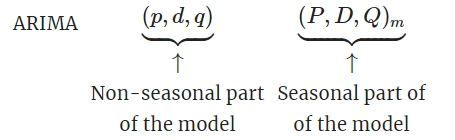




##### Exogenous:
* Útil para problemas multivariados.

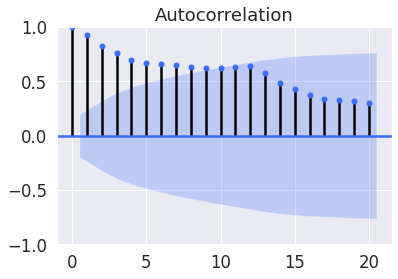

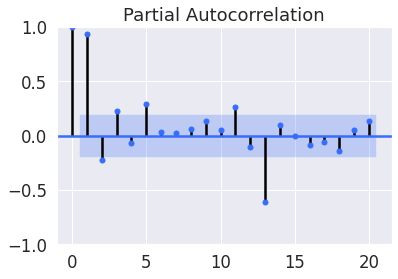

In [ ]:
plot_acf(train["#Passengers"]);
plot_pacf(train["#Passengers"]);

In [ ]:
non_stationary = True
d = 0
diff_train = train
while non_stationary:
  diff_train = diff_train.diff().dropna()
  d = d + 1
  adf = adfuller(diff_train["#Passengers"])[1]
  non_stationary = adf >= 0.05

  if d > 10:
    raise Exception('It was not possible to get a stationary series with 10 diffs')

print("Number of diffs to make series stationary:", d)

Number of diffs to make series stationary: 2


In [ ]:
auto_model = (auto_arima(train["#Passengers"],
           seasonal=True,
           m=12,
           max_d=2,
           information_criterion='aicc'))

auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -319.101
Date:                            Wed, 26 Oct 2022   AIC                            644.203
Time:                                    20:40:30   BIC                            651.601
Sample:                                01-01-1949   HQIC                           647.182
                                     - 04-01-1957                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2434      0.097     -2.512      0.012      -0.433      -0.054
ar.S.L12      -0.2127      0.087     -2.432      0.015      -0.384      -0.041
sigma2        89.1842     14.080      6.334      0.000      61.587     116.781
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.43
Prob(Q):                              0.97   Prob(JB):                         0.30
Heteroskedasticity (H):               1.32   Skew:                             0.40
Prob(H) (two-sided):                  0.46   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

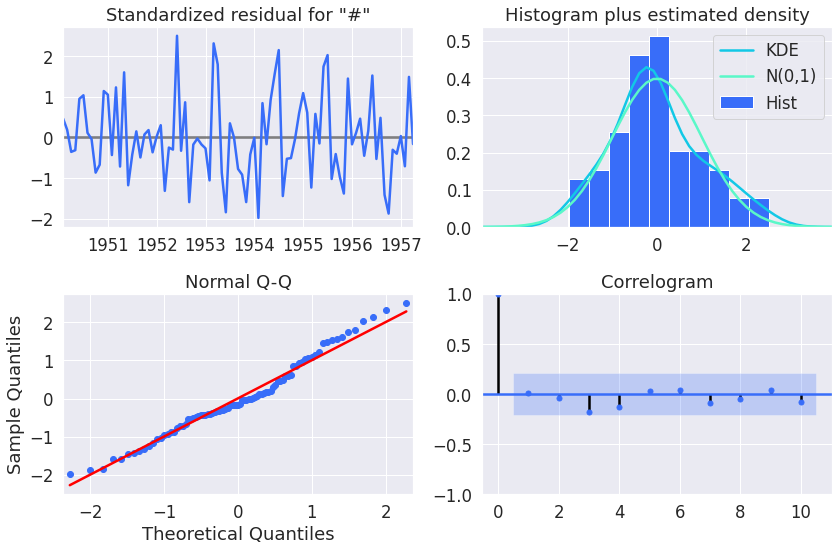

In [ ]:
sarima_model=(SARIMAX(endog=train["#Passengers"],
               order=(1,1,2),
               seasonal_order=(1,1,0,12),
               trend='c',
               enforce_invertibility=False))

sarima_fit=sarima_model.fit()

start = len(train)
end = len(train) +len(test) -1

sarima_fitted = sarima_fit.fittedvalues

sarima_resid = sarima_fit.resid

py_sarima = sarima_fit.predict(start, end, dynamic=False)

predictions["py_sarima"] = py_sarima

sarima_fit.plot_diagnostics(figsize = (12, 8));
plt.tight_layout()



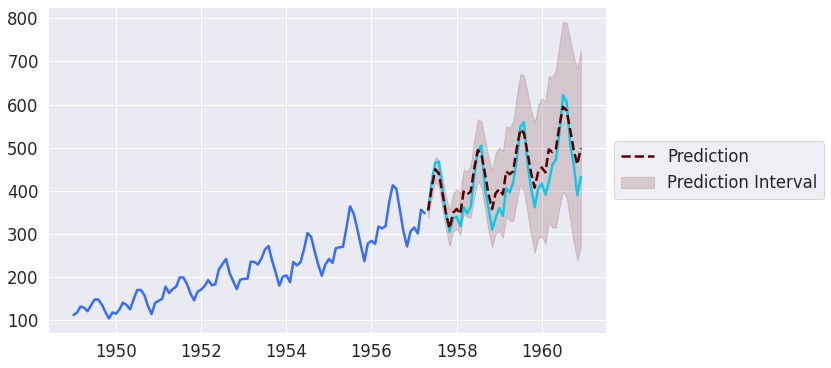

In [ ]:
forecast = sarima_fit.get_forecast(len(test))
conf = forecast.conf_int(alpha=0.05)
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(train.index, train.values);
ax.plot(test.index, test.values)
ax.plot(forecast.predicted_mean.index, forecast.predicted_mean.values, '--', color = '#530000', label = 'Prediction');
ax.fill_between(conf.index, conf['lower #Passengers'], conf['upper #Passengers'], color='#530000', alpha=.15, label = 'Prediction Interval');
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

In [ ]:
accuracy(predictions["#Passengers"], py_sarima)

,RMSE,%MAPE
0,35.5,7.7


** Mean of the residuals:  0.6

** Ljung Box Test, p-value: 0.898 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


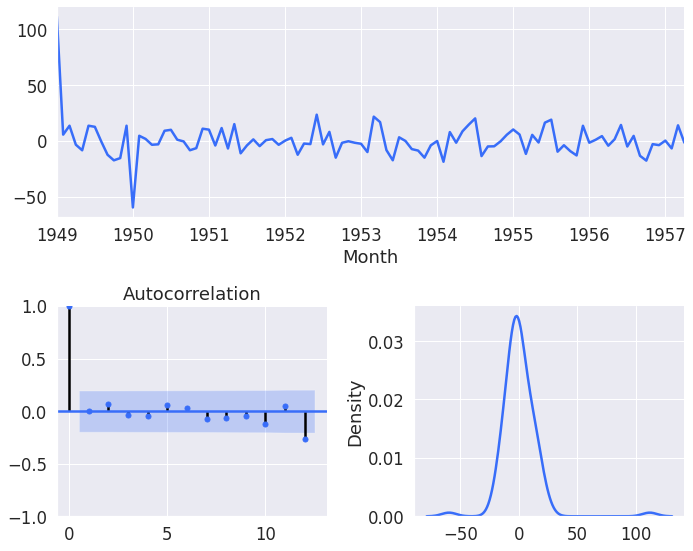

In [ ]:
residcheck(sarima_fit.resid, 12);

Com este primeiro modelo SARIMA, obtivemos resíduos que são nãocorrelacionados e não-normais. Pode ser que temos alguma informação restante no resíduo.

#### Triple Exponential Smoothing (Holt-Winter)

Este modelo decompõe a série temporal em nível, tendência e sazonalidade. Forecasting são feitos com base na combinação sistemática desses fatores nos lags recentes. A ideia intuitiva aqui é que o futuro vai se comportar de forma similar ao passado. Os três componentes são:
   - **Level**, ($\alpha$): O valor médio da série. Para séries sasonais, primeiro a sazonalidade é removida e depois a média é tomada. O valor $\alpha \in [0, 1]$ determina o quanto do passado deve ser considerado, sendo que $\alpha = 1$ significa que deve-se dar importância apenas ao último ponto disponível (naive forecast).
   - **Trend**, ($\beta$): A tendência diz o quanto o level muda ao longo do tempo. Similar ao $\alpha$, para $\beta$ próximos de 1, significa que vamos considerar apenas passado recente para analisar a tendência. Também existe um parâmetro de suavização $\phi$ que significao quanto da tendência recente vamos "esquecer".
   - **Seasonality** ($\gamma$): Este fator modela como a série se comporta em cada período dentro de um mesmo intervalo de sazonalidade.

* Additive model = (Level + Trend) + Seasonality
* Multiplicative Model = (Level * Trend) * Seasonality

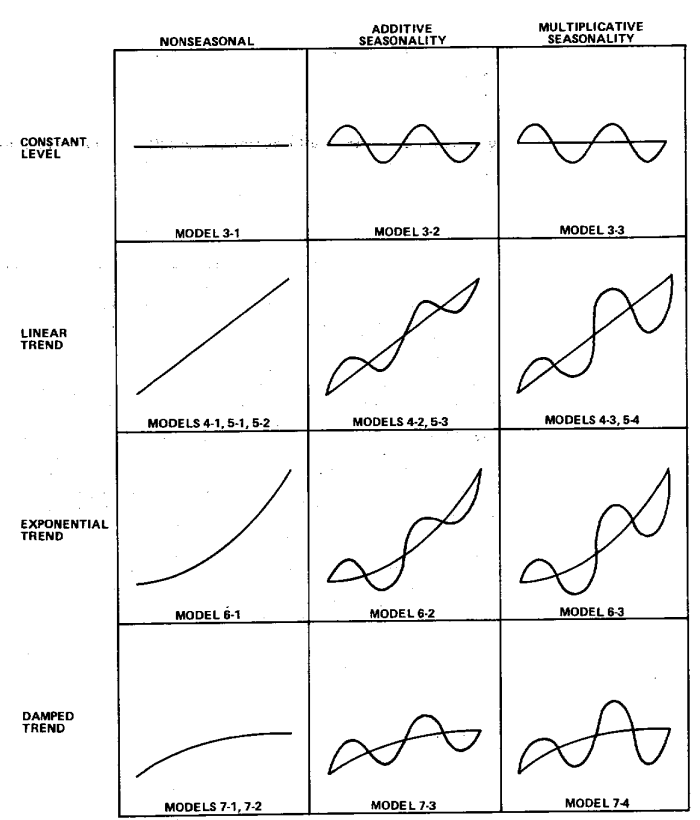


Extraído de https://www.bauer.uh.edu/gardner/docs/pdf/Exp-Sm-1985.pdf

In [ ]:
trend      = ['add','mul']
seasonal   = ['add','mul']
damped     = [False, True]
use_boxcox = [False, True, 'log']

model = ExponentialSmoothing(train,
                             trend = 'add',
                             damped = False,
                             seasonal='mul',
                             seasonal_periods = 12).fit()

fc = model.forecast(len(test))


In [ ]:
accuracy(predictions["#Passengers"], fc)

,RMSE,%MAPE
0,31.9,5.6


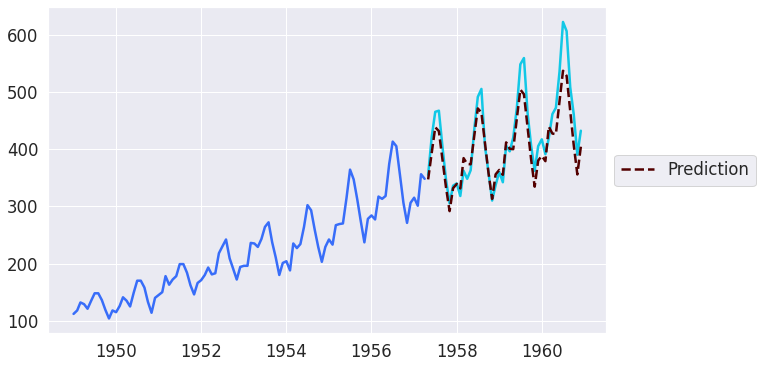

In [ ]:
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(train.index, train.values);
ax.plot(test.index, test.values)
ax.plot(test.index, fc, '--', color = '#530000', label = 'Prediction');
# ax.fill_between(test.index, conf[:,0], conf[:,1], color='#530000', alpha=.15, label = 'Prediction Interval');
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

** Mean of the residuals:  402.34

** Ljung Box Test, p-value: 0.0 (<0.05, Correlated)

** Jarque Bera Normality Test, p_value: 0.446 (>0.05, Normal)

** AD Fuller, p_value: 0.956 (>0.05, Non-stationary)


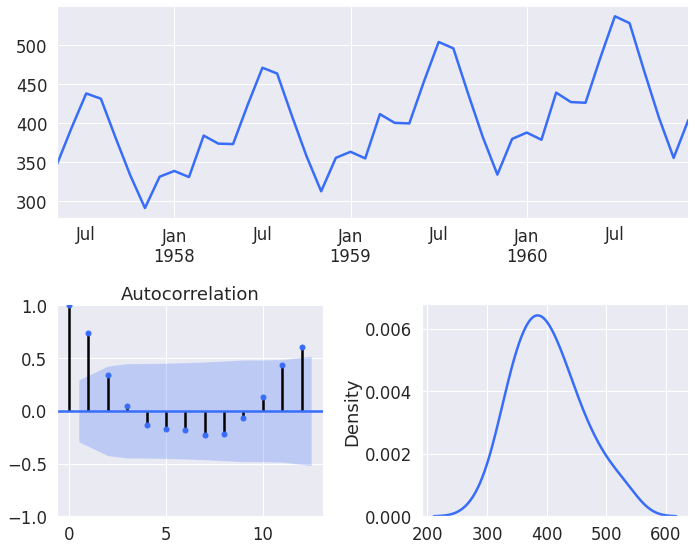

In [ ]:
residcheck(fc, 12);

#### ETS (Exponential Smoothing)

ETS na verdade significa um modelo Error, Trend e Seasonality. É similar ao modelo de Holt-Winter, porém feito em cima de um framework State-Space. Estes modelos representam de forma probabilística os estados (level, trend e seasonality).

ETS segue a seguinte taxonomia. Sendo, ETS(XYZ):
   - X:Error (innovations). Pode ser Aditivo ($A$) ou Multiplicativo ($M$)
   - Y:Trend. No trend ($N$), Aditivo ($A$), Multiplicativo ($M$) e suavizado ($A_d$)
   - Z:Seasonality, No Seasonality ($N$), Aditivo ($A$) or Multiplicativo ($M$)

Portanto, um ETS(ANN) é um modelo exponencial com erro aditivo, sem tendência e sazonalidade. Podemos ter 24 combinações diferentes e, portanto, 24 modelos ETS.

In [ ]:
ets = sm.tsa.statespace.ExponentialSmoothing(train.values,
                                           trend=True,
                                           initialization_method= 'heuristic',
                                           seasonal=12).fit()

fc = ets.get_forecast(len(test))

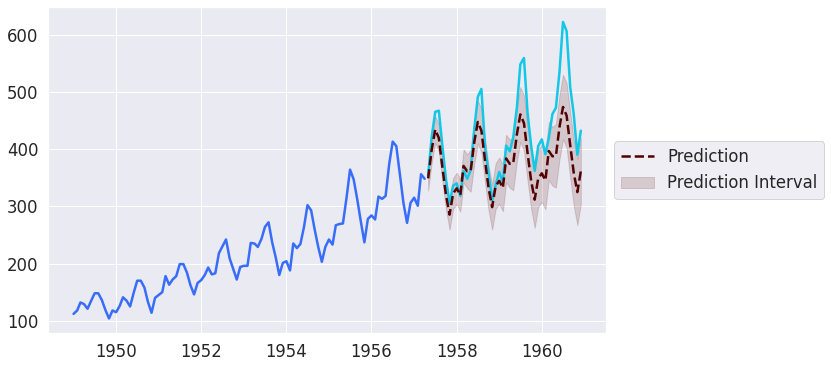

In [ ]:
conf = fc.conf_int(alpha=0.05)
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(train.index, train.values);
ax.plot(test.index, test.values)
ax.plot(test.index, fc.predicted_mean, '--', color = '#530000', label = 'Prediction');
ax.fill_between(test.index, conf[:,0], conf[:,1], color='#530000', alpha=.15, label = 'Prediction Interval');
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

In [ ]:
accuracy(predictions["#Passengers"], fc.predicted_mean)

,RMSE,%MAPE
0,60.0,10.2


** Mean of the residuals:  3.39

** Ljung Box Test, p-value: 0.0 (<0.05, Correlated)

** Jarque Bera Normality Test, p_value: 0.001 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


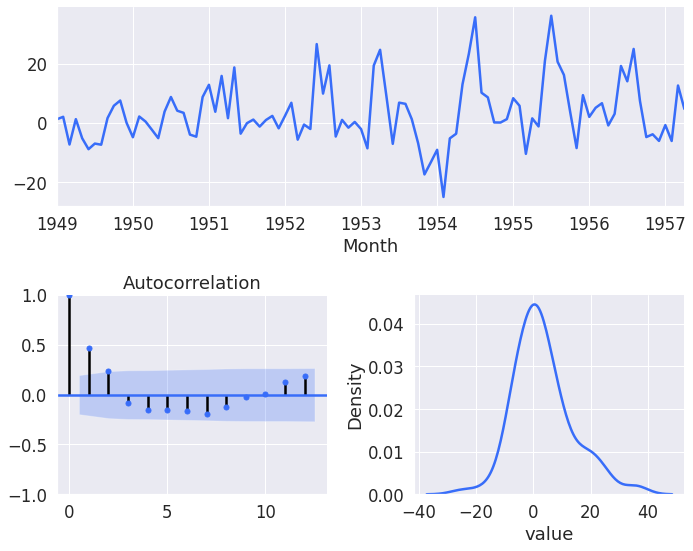

In [ ]:
result = pd.DataFrame([], index = train.index)
result['value'] = ets.resid
residcheck(result['value'], 12);

### Incertezas

Forecasts são probabilísticos. É importante que se quando apresentar resultados de um forecasting levar em consideração as incertezas atreladas à este processo. Essas incertezas podem vir de:
1. Ruídos inerentes ao processo
2. Dos parâmetros utilizados
3. A escolha do modelo
4. Incertezas nos dados

Não é possível estimar todas as fontes de incerteza. Portanto, é necessário que os usuários do forecasting estejam cientes das incertezas envolvidas nas previsões e saibam os intervalos de confiança, risco atrelado e até mesmo o pior caso.

Podemos fazer simulações para analisar esses dados.

#### Simulação

Vamos imaginar que o CEO da Cia aérea queira saber o total de passageiros no inrtervalo de teste. A maneira mais óbvia é fazer o forecasting e somas os resultados de todos os meses. Essa pode ser uma boa estimativa, porém não é a melhor maneira de se calcular tal resultado. É necessário contabilizar as incertezas em cada uma das previsões. Se os forecasts foram com base em mediana (ou algum outro percentil), então não se pode somá-los.

Para isso, vamos realizar uma simulação de Monte Carlo para se calcular os indicadores necessários.

In [ ]:
s = ets.simulate(len(test),
                 anchor = len(train),
                 repetitions=5000 )
simulation = pd.DataFrame(np.reshape(s, (len(test), 5000)).T)

In [ ]:
simulation = pd.DataFrame(np.reshape(s, (len(test), 5000)).T)
total_passengers = simulation.sum(axis =1)

In [ ]:
total_passengers.mean()

16506.455650806896

In [ ]:
total_passengers.quantile([0.25, 0.75])

0.25    16045.038102
0.75    16963.870317
dtype: float64

In [ ]:
simulation

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43
0,344.336952,401.662674,427.128059,423.640670,369.029549,320.902397,294.043254,326.720884,343.425145,320.878378,388.913353,359.907131,356.503984,423.649377,463.555885,458.194682,378.354769,341.055829,313.519574,337.456928,359.002186,328.553632,403.508723,385.312064,400.084847,435.725632,481.988777,460.993110,395.656205,354.500281,337.321444,370.446508,397.327736,357.423443,453.877130,393.491882,404.694335,461.029598,506.983317,473.851769,421.933226,357.595578,353.939133,368.137636
1,363.149423,402.070531,440.117554,405.601749,370.675909,329.828978,298.814946,332.698406,358.278200,324.608543,387.914851,372.730639,385.903349,439.722579,473.032457,444.369629,407.743327,362.820018,321.409314,358.340691,368.807230,339.492245,409.364162,392.406289,408.848355,438.374868,480.901167,459.737159,423.099359,388.037536,344.878416,395.078354,384.325066,383.383038,438.118252,401.789702,423.199385,446.938278,490.690172,482.302648,439.254393,398.077189,348.979143,380.087844
2,334.680552,384.535473,424.221082,417.236285,372.488707,332.670382,306.868529,327.964027,339.758629,337.536134,383.617413,374.419703,391.216707,427.226264,454.040075,450.862153,420.009124,359.345491,340.100904,359.733431,354.409553,369.111357,397.923989,399.926163,390.819177,435.244624,462.529428,461.371894,437.059033,391.976524,358.277758,375.032166,356.378674,380.098838,414.718020,402.454577,389.086931,451.113058,467.838365,475.635512,427.191995,391.784598,343.696148,385.651669
3,340.718050,398.920961,446.872896,415.263916,356.422023,338.922092,302.733837,316.152497,331.381960,315.677431,359.927936,369.765819,385.446650,429.178489,460.216146,450.584813,386.379048,368.879348,322.906029,319.178132,339.336356,336.889944,388.943325,388.574851,385.000849,432.794402,459.232473,459.516004,384.769401,390.213409,312.456682,328.527124,354.745820,339.951955,399.886999,389.883811,395.620164,452.385704,477.754601,474.982500,413.072933,406.649467,326.798145,339.840595
4,337.001916,375.012847,414.352516,399.143425,372.609707,314.992722,277.865118,297.746569,314.458797,321.014118,355.471010,370.664695,367.709079,410.666726,441.980409,433.522506,392.981181,345.875541,310.556598,326.401941,333.761851,350.494898,371.231779,353.410477,386.157973,420.129233,438.353842,460.573340,416.764812,377.742909,323.718800,346.737470,373.834416,380.284354,398.575774,381.550191,421.897624,453.048107,476.183635,504.313544,451.977900,392.049980,349.974676,376.961831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,344.419473,378.603226,423.368633,409.302665,372.145789,311.145597,278.726988,318.220685,333.707448,310.351522,360.231327,343.860217,341.812767,379.181179,426.979597,408.584719,377.790706,313.838655,274.972344,320.302305,334.278299,320.005124,362.300719,365.845272,355.574007,397.064613,462.295297,443.086196,400.418220,359.058727,315.086312,363.516953,347.010880,345.710386,393.144567,372.031033,389.887279,417.059042,485.210613,443.991482,409.059863,364.674774,322.974346,370.300845
4996,333.561456,397.714900,443.656282,398.019695,373.933735,329.220603,281.709780,301.114896,337.599842,318.025552,364.061430,371.894258,336.896049,415.807404,457.718835,422.750966,386.471039,350.975826,321.021808,328.104769,382.613280,346.955662,401.172064,407.916115,368.975269,447.142985,510.429401,476.190869,423.537144,384.309488,349.504916,365.354792,411.219272,378.008651,436.268973,447.747268,389.539607,479.076835,539.680828,495.995520,443.724977,416.811521,378.644720,406.357580
4997,360.600694,397.995362,449.774909,394.637883,360.311235,306.168899,275.347355,310.722044,309.737515,296.515618,353.249409,347.010003,360.492005,391.341704,442.970602,412.691682,360.293088,331.863037,296.510350,318.653486,320.132975,327.654949,379.574719,360.150165,377.477446,412.55010

### Intervalos de Confiança


In [ ]:
q1_975=np.quantile(simulation.iloc[:,1],0.975)
q1_025=np.quantile(simulation.iloc[:,1],0.025)

print("PI_95%:", q1_975.round(1))
print("PI_5%:", q1_025.round(1))

PI_95%: 421.4
PI_5%: 377.0


In [ ]:
#Reference: http://stanford.edu/~raejoon/blog/2017/05/16/python-recipes-for-cdfs.html

num_bins = 100
counts, bin_edges = np.histogram (total_passengers, bins=num_bins, normed=True)
cdf = np.cumsum (counts)
cdf_x = bin_edges[1:]
cdf_y = cdf/cdf[-1]
cdf_df = pd.DataFrame({'#Passengers':cdf_x, 'Percentile':cdf_y})
cdf_df.head()

,#Passengers,Percentile
0,14088.516924,0.0002
1,14137.103079,0.0002
2,14185.689233,0.0004
3,14234.275388,0.0004
4,14282.861542,0.0006


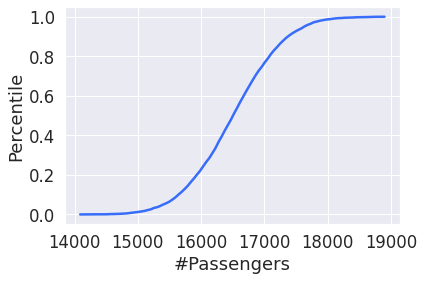

In [ ]:
sns.lineplot(cdf_df['#Passengers'], cdf_df['Percentile']);

## Problemas multivariados

[Link 1](https://analyticsindiamag.com/how-to-use-xgboost-for-time-series-analysis/#:~:text=Using%20XGBoost%20for%20time%2Dseries,results%20and%20speed%20of%20modelling.&text=XGBoost%20is%20an%20efficient%20technique%20for%20implementing%20gradient%20boosting.)

[Link 2](https://machinelearningmastery.com/xgboost-for-time-series-forecasting/)




### Feature Engineering

* https://tsfresh.readthedocs.io/en/latest/

* https://tsfel.readthedocs.io/en/latest/

### Recursive Modeling

https://towardsdatascience.com/how-to-improve-recursive-time-series-forecasting-ff5b90a98eeb

### Hierarchical Forecasting

https://github.com/nixtla/hierarchicalforecast/

### Probabilistic Forecasting

https://github.com/uber/orbit

## Outros Tipos de Modelagem

### Point Change Estimation

- Are there any structural breaks (shifts) in the series. Structural breaks are abrupt changes in the trend. Gather more information about the sudden changes. If the breaks are valid, ETS/ARIMA models wont work. FB Prophet, dynamic regression, deep learning models, adding more features might help. Identify the possible reasons for change, e.g. change in macros, price change, change in customer preferenaces etc. Note structural change persists for some time, while outliers do not. Break points are different from non-stationarity. Read more [here](http://faculty.baruch.cuny.edu/smanzan/FINMETRICS/_book/time-series-models.html#structural-breaks-in-time-series) for examples & explanations. In case of structural break-points, consider modeling the segments of the series separately.

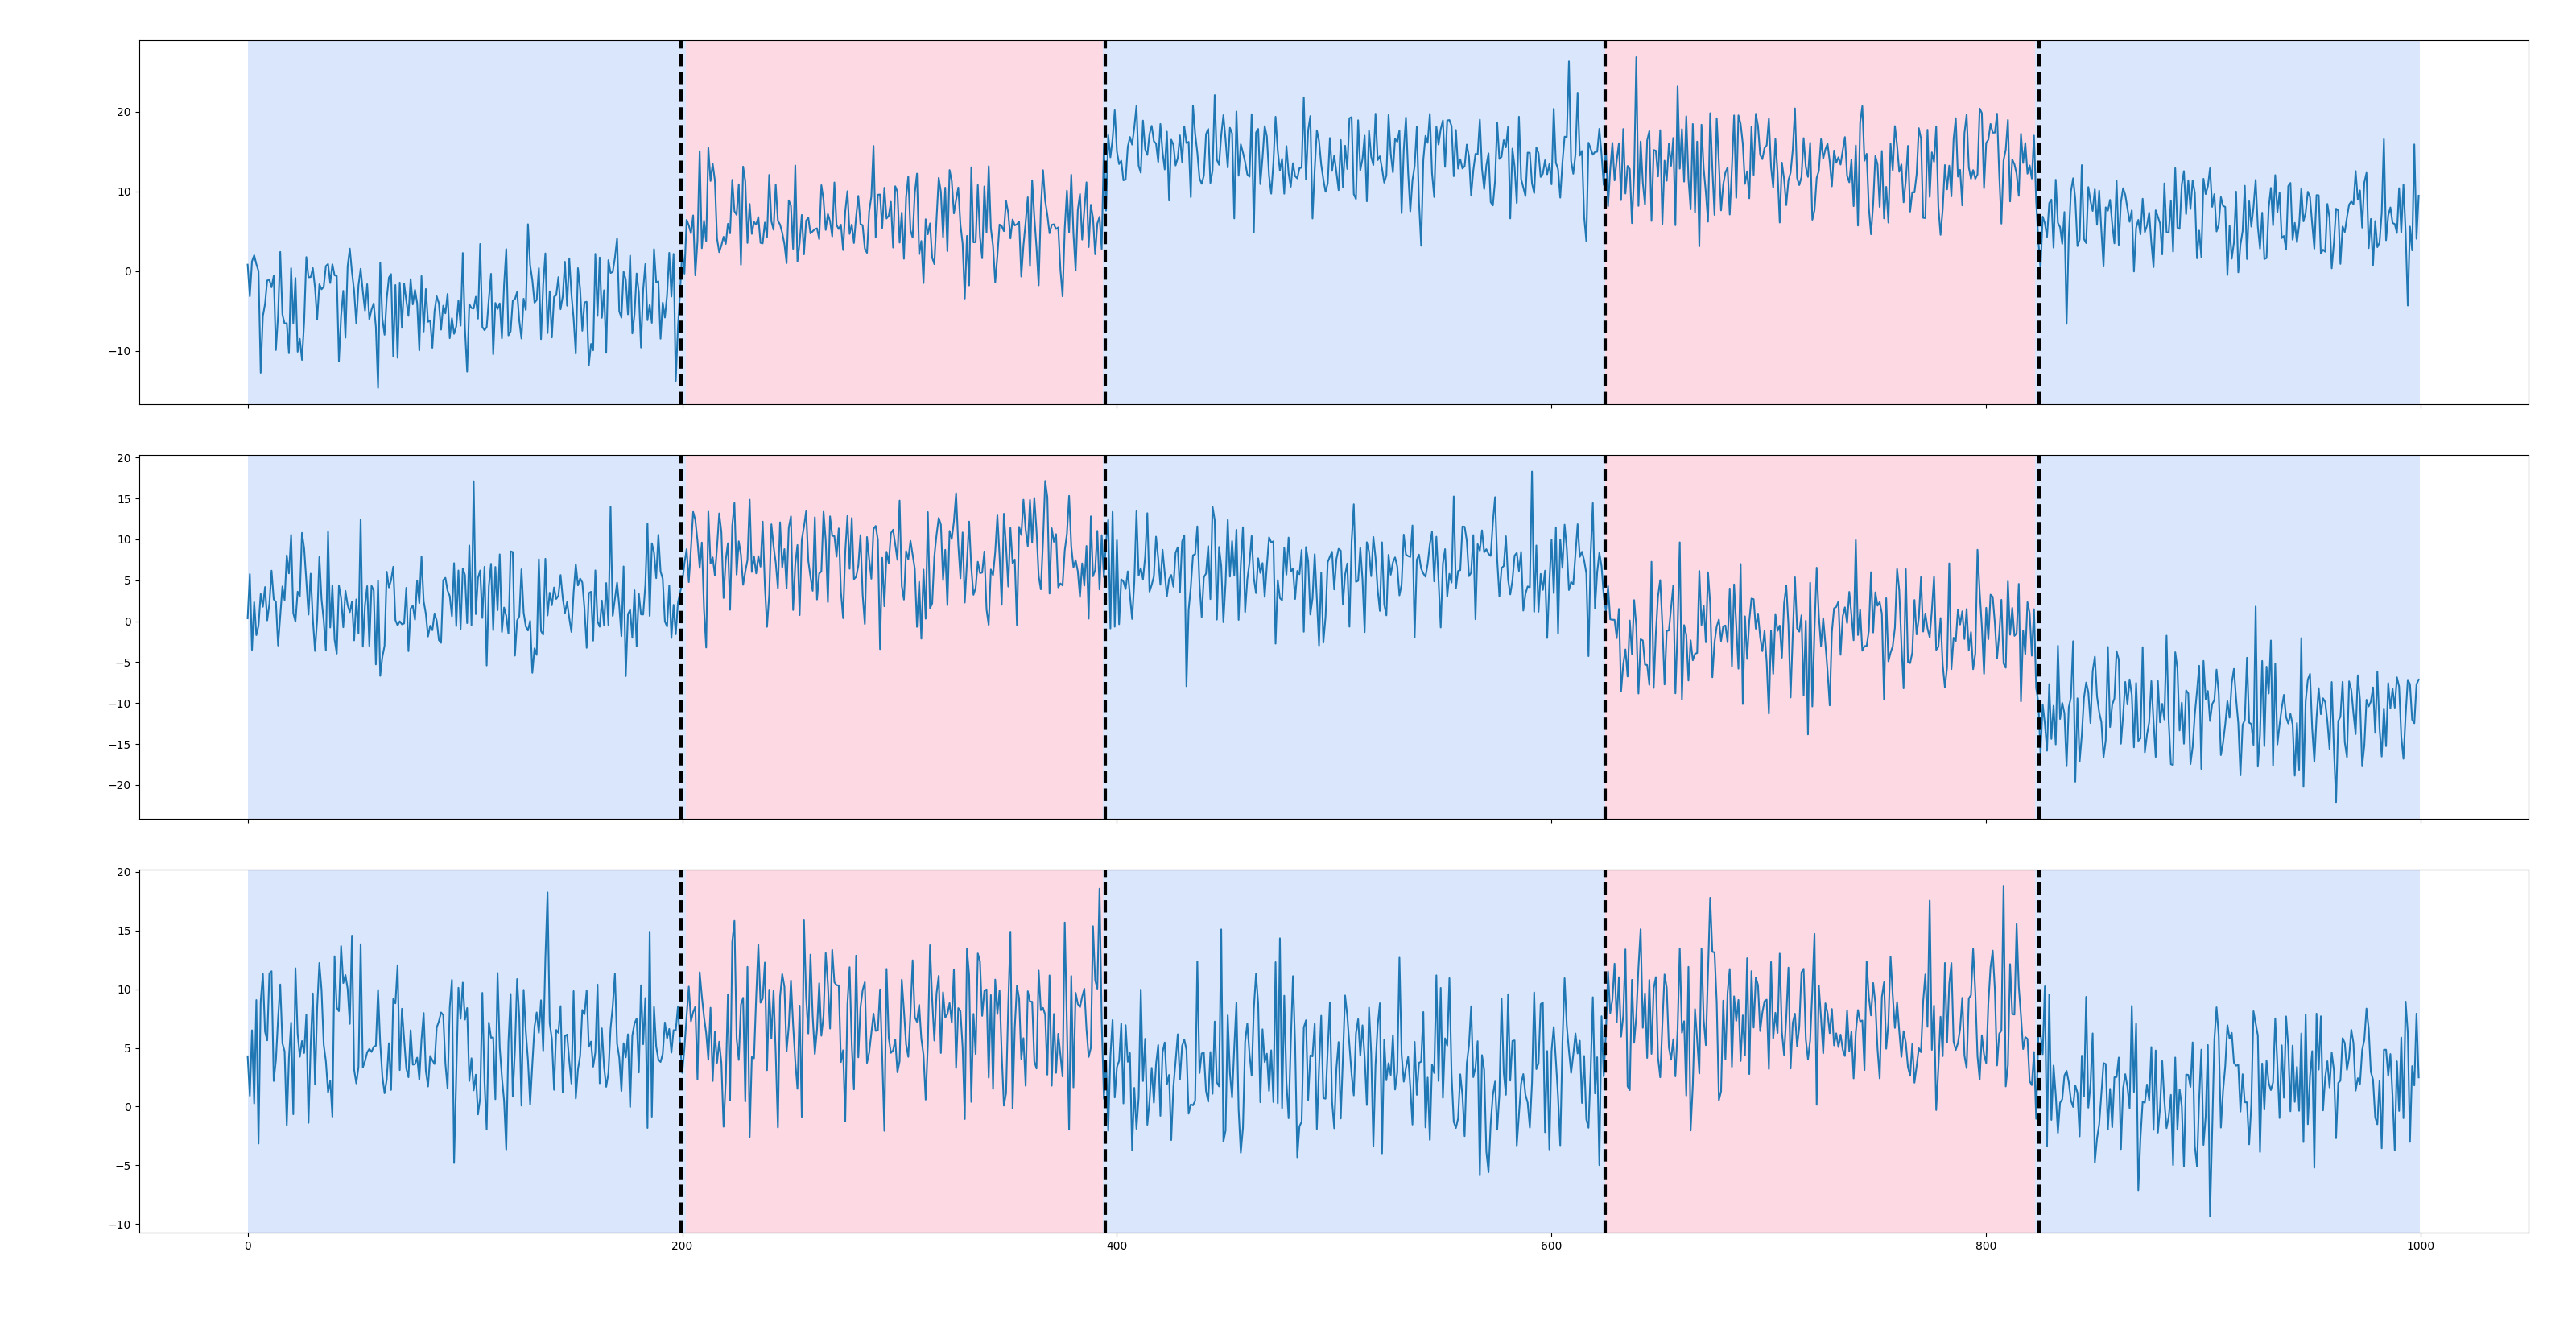

### Clustering



https://stumpy.readthedocs.io/en/latest/Tutorial_STUMPY_Basics.html

https://tslearn.readthedocs.io/en/stable/user_guide/clustering.html

**Dynamic Time Warping**

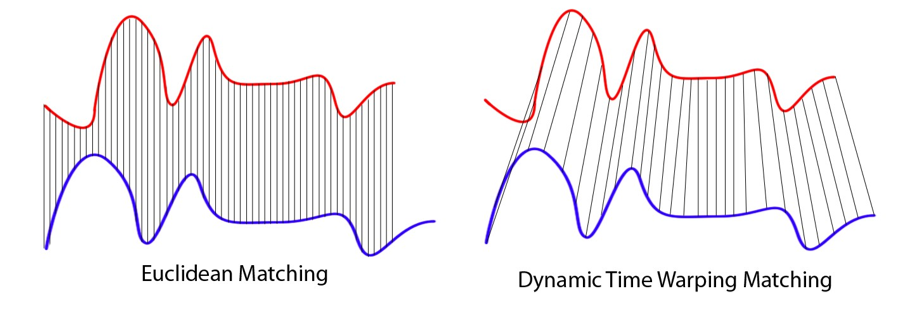


## Pacotes Úteis para Time-series
* Stumpy
* Ruptures
* Tslearn
* TSFresh
* Prophet
* Darts
* https://github.com/Nixtla/statsforecast
* Nixtla

## Referências:
   1. Forecasting: Principles and Practice, Prof. Hyndman (https://otexts.com/fpp2/)
   2. Time Series Analysis and its Applications, Robert Shumway
   3. Time Series Analysis and Forecasting, Montgomery  & Jennings
   4. Introduction to Time Series and Analysis, Brockwell
   5. Practial Time Series Forecasting with R, Galit Shmueli